# Model Build

In [18]:
# %history -g -f jm_trg.py

In [19]:

import os
import math
import numpy as np
from typing import Any
import tensorflow as tf
import tensorflow.keras as k
import matplotlib.pyplot as plt
import metrics
from pandas import DataFrame, crosstab
from metrics import plot_confusion
from IPython.display import Image
from tensorflow.keras import models
from keras.utils import plot_model
from tqdm.notebook import trange
from tensorflow.keras.layers import Dense, Input, Layer, InputSpec, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.initializers import VarianceScaling
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.cluster import KMeans
from sklearn.metrics import (
            f1_score, accuracy_score, precision_score, recall_score, classification_report)
from data import load_data
from wordcloud import WordCloud
import seaborn as sns
import umap

In [20]:
from sklearn.metrics import pairwise
def pairwise_sqd_distance(X, batch_size):
    return pairwise.pairwise_distances(X, metric='sqeuclidean')

    tiled = tf.tile(tf.expand_dims(X, axis=1), tf.stack([1, batch_size, 1]))
    tiled_trans = tf.transpose(tiled, perm=[1,0,2])
    diffs = tiled - tiled_trans
    sqd_dist_mat = tf.reduce_sum(tf.square(diffs), axis=2)

    return sqd_dist_mat

def make_q(z, batch_size, alpha):

    sqd_dist_mat = np.float32(pairwise_sqd_distance(z, batch_size))
    q = tf.pow((1 + sqd_dist_mat/alpha), -(alpha+1)/2)
    q = tf.linalg.set_diag(q, tf.zeros(shape=[batch_size]))
    q = q / tf.reduce_sum(q, axis=0, keepdims=True)
    # q = 0.5*(q + tf.transpose(q))
    q = tf.clip_by_value(q, 1e-10, 1.0)
    
    return q

In [21]:
from linear_assignment import linear_assignment

def cluster_acc(y_true, y_pred, y_pred_cluster):
    y_true = y_true.astype(np.int64)
    assert y_pred_cluster.size == y_true.size
    D = max(y_pred_cluster.max(), y_true.max()) + 1
    w = np.zeros((D, D), dtype=np.int64)
    for i in range(y_pred_cluster.size):
        w[y_pred[i], y_true[i]] += 1
    ind = linear_assignment(w.max() - w)
    c_loss = sum([w[i, j] for i, j in ind]) * 1.0 / y_pred_cluster.size
    print(f"Cluster Loss {c_loss} on {y_pred_cluster.size} clusters")
    return c_loss

In [22]:
from tabnanny import verbose
from sklearn.cluster import KMeans, DBSCAN, OPTICS, AgglomerativeClustering
from sklearn import mixture
from scipy.stats import multivariate_normal

def do_clustering(
        clustering: str, n_clusters: int, z_state: DataFrame, params={}):
    """
    Perform clustering on the data.
        -clustering: the clustering algorithm to use
        -n_clusters: the number of clusters to use
        -z_state: the data to cluster
        -params: dict, optional
            'eps' or 'min_samples' values for DBSCAN/OPTICS
    Returns:
        - the cluster assignments
        - cluster centers
    """
    dbscan_eps = 1
    dbscan_min_samples = 5
    
    if 'eps' in params:
        dbscan_eps = params['eps']
    if 'min_samples' in params:
        dbscan_min_samples = params['min_samples']

    if clustering == 'GMM':
        gmix = mixture.GaussianMixture(
                        n_components=n_clusters,
                        covariance_type='full',
                        verbose=2)
        gmix.fit(z_state)
        y_pred = gmix.predict(z_state)
        # get centres
        centers = np.empty(shape=(gmix.n_components, z_state.shape[1]))
        for i in range(gmix.n_components):
            density = multivariate_normal(
                cov=gmix.covariances_[i],
                mean=gmix.means_[i]).logpdf(z_state)
            centers[i, :] = z_state[np.argmax(density)]
    elif clustering == 'Kmeans':
        kmeans = KMeans(n_clusters=n_clusters, n_init=10)
        y_pred = kmeans.fit_predict(z_state)
        centers = kmeans.cluster_centers_
    elif clustering == 'DBSCAN':
        dbscan = DBSCAN(
            eps=dbscan_eps,
            min_samples=dbscan_min_samples,
            metric='manhattan')
        y_pred = dbscan.fit_predict(z_state)
        centers = np.zeros((len(np.unique(y_pred))))
    elif clustering == 'OPTICS':
        optics = OPTICS(
            min_samples=dbscan_min_samples, 
            min_cluster_size=5,
            metric='manhattan')
        y_pred = optics.fit_predict(z_state)
        centers = np.zeros((len(np.unique(y_pred))))
    elif clustering=="agg":
        agg = AgglomerativeClustering(
            n_clusters=n_clusters,
            affinity='manhattan',
            linkage='average')
        y_pred = agg.fit_predict(z_state)
        centers = None
    else:
        raise ValueError('Clustering algorithm not specified/unknown.')

    return y_pred, centers

In [23]:
def freqs_descending(df, col):
    uniques, counts = np.unique(df[col], return_counts=True)
    freq_list = np.asarray((uniques, counts)).T
    freq_list2 =  np.asarray(sorted(freq_list, key=lambda x: -x[1]))
    # purity
    y_true_this_cluster = len(
            df[df[col]==freq_list2[0][0]])
    frac = y_true_this_cluster/len(df)
    return freq_list2, frac

In [24]:
# write_messages.py

from jinja2 import Environment, FileSystemLoader
from pathlib import Path

def write_results_page(clusters, new_clusters, save_dir, test_name, scores):
    
    environment = Environment(loader=FileSystemLoader("templates/"))
    template = environment.get_template("index.jinja")

    results_filename = os.path.join(save_dir, "index.html")
    results_template = environment.get_template("index.jinja")
    context = {
        "clusters": clusters,
        "new_clusters": new_clusters,
        "test_name": test_name,
        "metrics": scores,
    }
    with open(results_filename, mode="w", encoding="utf-8") as results:
        results.write(results_template.render(context))
        full_filename = Path(results_filename).absolute()
        print (f'... wrote results  <a href="{full_filename}">{full_filename}</a>')

In [25]:
from ast import NamedExpr


def show_wordcloud(
    i: int,
    freqs: np.ndarray,
    frac: float,
    name: str,
    filepath: str,
    n: int,
    width: int=16,
    save_only: bool=False)-> None:
    """
    Show wordcloud for a cluster.
    """
    if len(freqs) > 0:
        wc = WordCloud(width=800, height=500).generate_from_frequencies(freqs)
        if not save_only:
            plt.figure(figsize=(width, width-1))
            plt.imshow(wc, interpolation='bilinear')
            plt.axis("off")
            plt.show()
        wc.to_file(filepath)
    else:
        print(f"No words for cluster {name}")

In [26]:
import warnings
warnings.filterwarnings("ignore")

ENTITY_FILTER_LIST = ['GPE', 'PERSON', 'ORG', 'DATE', 'NORP',
                      'TIME', 'PERCENT', 'LOC', 'QUANTITY', 'MONEY', 'FAC', 'CARDINAL',
                      'EVENT', 'PRODUCT', 'WORK_OF_ART', 'ORDINAL', 'LANGUAGE']


class DeepLatentCluster():

    def __init__(
        self,
        run_name: str,
        config: dict = None,
        verbose: int = 1,
    ):

        self.x = None
        self.y = None
        self.mapping = None
        self.strings = None
        self.y_pred_last = None
        self.input_dim = 768
        self.batch_size = 256

        self.run_name = run_name
        self.model = None
        self.encoder = None
        self.autoencoder = None
        self.save_dir = None
        self.verbose = verbose

        # latent model config
        self.config = {
            "layers_ae": [
                {"n": 500, "act": None},
                {"n": 500, "act": None},
                {"n": 2000, "act": None},
            ],
            "layer_ae_latent":
                {"n": 40, "act": None},
            "layers_latent_network": [
                {"n": 2000, "act": None},
                {"n": 500, "act": None},
                {"n": 500, "act": None},
            ],
            "output_fn": 'sigmoid',
            "opt": k.optimizers.Adam(
                lr=0.001,
                beta_1=0.9,
                beta_2=0.999,
                epsilon=None,
                decay=0.0,
                amsgrad=False),
            "loss": k.losses.binary_crossentropy,
            "train_size": 10000,
            "num_clusters": 25,
            "cluster": "GMM",
            "entities": None,
            "entity_count": 10,
            "loss_weights": None,
            "latent_weight": 0.0001,
            "reconstr_weight": 1.0,
            "max_iter": 8000,
            "pretrain_epochs": 300,
            "emb_size": 768,
            "alpha1": 20,
            "alpha2": 1,
            "ae_init_fn": VarianceScaling(
                mode='fan_in',
                scale=1. / 3.,
                distribution='uniform'),
            "base_dir": "results",
        }
        if config is not None:
            self.config = {**self.config, **config}
        if self.config['entities'] is not None and self.config['entity_count'] > 0:
            raise ValueError(
                'entities and entity_count cannot both be specified')
        if self.config['entities'] is None:
            if self.config['entity_count'] == 0:
                self.config['entities'] = ENTITY_FILTER_LIST
            else:
                self.config['entities'] = ENTITY_FILTER_LIST[
                    :self.config['entity_count']]


        self.save_dir = f'./{self.config["base_dir"]}/{self.run_name}'
        if not os.path.exists(self.save_dir):
            # create save dir
            os.makedirs(self.save_dir)

    def output(self, s: str) -> None:
        if self.verbose > 0:
            print(s)

    def make_data(self, oversample: bool = True, train: bool=True) -> None:

        self.output("Load Data")
        self.x, self.y, self.mapping, self.strings = load_data(
            self.config['train_size'],
            entity_filter=self.config['entities'],
            get_text=True,
            oversample=oversample,
            verbose=self.verbose,
            train=train)
        self.input_dim = self.x.shape[1]
        self.output("Data Loaded")

    @staticmethod
    def create_layer(config: dict, name: str, init_fn: str = 'glorot_uniform') -> Dense:
        """
        Create a layer from a config dictionary.
        - config: dictionary of layer parameters
            - n: number of units
            - act: activation function
        """
        return Dense(
            name=name,
            units=config["n"],
            activation=config["act"],
            kernel_initializer=init_fn,
            kernel_regularizer='l1')

    def autoencoder_model(self, layer_specs: list, act: str = 'tanh', init_fn: str = 'glorot_uniform', verbose=0):
        """
        Creates the autoencoder given
        -layer_specs: list of layer sizes.
            Model is symmetrical so only need to specify the first half.
        -act: activation function for hidden layers
        -init_fn: initializer for weights

        returns:
            - the full autoencoder
            - the encoder only
        """
        layers = len(layer_specs) - 1
        # input
        input_img = Input(shape=(layer_specs[0],), name='input')
        x = input_img
        encoder = [input_img]
        # hidden layers in encoder
        for i in range(layers-1):
            layer = Dense(
                layer_specs[i + 1],
                activation=act,
                kernel_initializer=init_fn,
                name=f'encoder_{i}')(encoder[-1])
            encoder += [layer]
            if verbose >= 2:
                print(f'encoder_{i}: {layer_specs[i+1]} '
                      f'activation={act}')

        # latent layer
        latent = Dense(
            layer_specs[-1],
            kernel_initializer=init_fn,
            name=f'encoder_{layers - 1}')(encoder[-1])
        encoder += [latent]
        if verbose >= 2:
            print(f'encoder_{layers - 1}: {layer_specs[-1]}')

        autoencoder = [encoder[-1]]
        # hidden layers in decoder
        for i in range(layers-1, 0, -1):
            layer = Dense(
                layer_specs[i],
                activation=act,
                kernel_initializer=init_fn,
                name=f'decoder_{i}')(autoencoder[-1])
            autoencoder += [layer]
            if verbose >= 2:
                print(f'encoder_{i}: {layer_specs[i]}'
                      f' activation={act}')

        # output
        layer = Dense(
            layer_specs[0],
            kernel_initializer=init_fn,
            name='decoder_0')(autoencoder[-1])
        autoencoder += [layer]
        if verbose >= 2:
            print(f'output: {layer_specs[0]}'
                  f'')
        return (encoder, autoencoder)

    def create_latent_space_model(self, input_layer: Dense) -> Model:
        """
        Create the model for the latent space
        - input_layer: previous model output layer
        """
        # build ml, the array of layers
        ml = [input_layer]
        layers = self.config['layers_latent_network']
        for n, l in enumerate(layers):
            ml.append(self.create_layer(l, f"latent_{n}")(ml[-1]))

        out_config = {**layers[0], "act": self.config['output_fn']}
        ml.append(self.create_layer(out_config, "latent_out")(ml[-1]))
        return ml

    def create_model(self) -> Model:
        """
        Create the entire model.

        """
        print("Autoencoder")
        # enc = self.create_ae_encoder_model()
        # dec = self.create_ae_decoder_model(
        #     input_layer=enc[-1])

        enc, dec = self.autoencoder_model(
            [768, 500, 500, 2000, 40],
            init_fn=self.config['ae_init_fn'],
            act='relu',
            verbose=self.verbose)
        print("Latent Model")

        latent_space = self.create_latent_space_model(
            input_layer=enc[-1])
        self.model = k.Model(
            name="full-model",
            inputs=enc[0],
            outputs=[
                dec[-1],
                latent_space[-1],
            ])

        self.autoencoder = k.Model(
            name="ae-model",
            inputs=enc[0],
            outputs=[
                dec[-1],
            ])

        self.encoder = k.Model(
            name="encoder",
            inputs=enc[0],
            outputs=[
                enc[-1],
            ])

    def make_model(self) -> None:
        self.create_model()

        self.model.compile(
            loss=[
                self.latent_loss(
                    self.model.get_layer("encoder_2").get_weights()[0])],
            # loss_weights=self.config['loss_weights'],
            optimizer=SGD(learning_rate=0.5, momentum=0.9))
        self.output("model compiled")

        self.autoencoder.compile(optimizer='adam', loss='mse')

        img_file = os.path.join(self.save_dir, f'{self.run_name}_model.png')
        plot_model(self.model, to_file=img_file, show_shapes=True)
        Image(filename=img_file)

    def reconstr_loss(self, x, x_pred):
        return tf.reduce_mean(tf.square(tf.subtract(x, x_pred)))

    def latent_loss(self, z_enc):
        def loss(y, y_pred):
            p = make_q(y_pred, self.batch_size, alpha=self.config['alpha1'])
            q = make_q(z_enc, self.batch_size, alpha=self.config['alpha2'])
            latent_loss = tf.reduce_sum(-(tf.multiply(p, tf.math.log(q))))
            return latent_loss
        return loss

    def train_model(self, verbose: int = 1) -> None:
        """
        Run the model.
        """
        if verbose:
            self.verbose = verbose

        if self.x is None:
            self.make_data(oversample=True)
            self.output("Data Loaded")

        if self.model is None:
            self.make_model()

        self.output("Training autoencoder")
        early_stopping_cb = EarlyStopping(
            monitor='loss', patience=10, verbose=1, min_delta=0.00001)
        history = self.autoencoder.fit(
            self.x,
            self.x,
            batch_size=self.batch_size,
            epochs=self.config["pretrain_epochs"],
            verbose=self.verbose,
            callbacks=[early_stopping_cb],
        )
        self.autoencoder.save_weights(
            os.path.join(self.save_dir, 'ae_weights.h5'))
        self.output("Trained autoencoder")
        if self.verbose > 0:
            # summarize history for loss
            plt.plot(history.history['loss'])
            plt.title('Autoencoder pretraining loss')
            plt.ylabel('loss')
            plt.xlabel('epoch')
            plt.show()

        # # init cluster centres before train
        # self.init_cluster_centers()

        # train full model
        losses = self.train()
        if self.verbose > 0:
            # summarize history for loss
            plt.plot(losses)
            plt.title('Full model loss')
            plt.ylabel('loss')
            plt.xlabel('epoch')
            plt.show()

        print("Training Done")

    def aux_target_distribution(self, q):
        # sum column wise
        row_sum = q.sum(axis=0)
        # q_ij ^2 / row sum
        top = q ** 2 / row_sum
        # then / column sum
        return (top.T / top.sum(axis=1)).T

    def train_step(self, x, y):
        with tf.GradientTape() as tape:
            dec, lat = self.model(x, training=True)
            loss_l = self.latent_loss(self.encoder(x))(y, lat)
            loss_r = self.reconstr_loss(x, dec)
            loss_value = self.config['latent_weight'] * loss_l +\
                self.config['reconstr_weight'] * loss_r

        grads = tape.gradient(loss_value, self.model.trainable_weights)
        optimizer = self.config['opt']
        optimizer.apply_gradients(zip(grads, self.model.trainable_weights))
        self.train_acc_metric.update_state(y, lat)
        return loss_value

    def train(self):
        self.train_acc_metric = k.metrics.SparseCategoricalAccuracy()

        update_interval = 140
        index_array = np.arange(self.x.shape[0])
        tol = 1e-6  # tolerance threshold to stop training
        loss = 0
        index = 0
        update_interval = 140
        losses = []
        for ite in range(int(self.config['max_iter'])):
            if ite % update_interval == 0:
                print(f"Iter:{ite} -> loss:{loss}")
            idx = index_array[
                index * self.batch_size:
                min((index+1) * self.batch_size, self.x.shape[0])]
            loss = self.train_step(self.x[idx], self.y[idx])
            losses += [loss]
            # stop training if tolerance threshold is reached
            patience = 5
            max_delta = np.max(np.abs(losses[-patience:] - losses[-1]))
            if len(losses)>3 and max_delta < tol:
                break
        if self.verbose == 0:
            # final values
            print(f'Iter: {ite} loss={loss}')
        self.model.save_weights(os.path.join(
            self.save_dir, 'lat_model_final.h5'))
        return losses

    def cluster_pred_acc(self):
        NER_only = DataFrame({'y': self.y, 'y_clus': self.y_pred})
        unk_tuple = [k for k, v in self.mapping.items() if v == 'UNKNOWN']
        unk_idx = unk_tuple[0] if len(unk_tuple) > 0 else None
        NER_only.drop(NER_only.index[NER_only['y'] == unk_idx], inplace=True)
        NER_match = NER_only[NER_only['y'] == NER_only['y_clus']]
        # fraction that match
        frac = NER_match.shape[0]/NER_only.shape[0]
        return frac

    def make_load_model(self, load_dir):
        self.make_model()

        if load_dir is None:
            load_dir = self.save_dir
        else:
            load_dir = f'./{self.config["base_dir"]}/{load_dir}'

        ae_weights_file  = os.path.join(load_dir, 'ae_weights.h5')
        self.output(f"Loading AE weights from {ae_weights_file}")
        self.autoencoder.load_weights(ae_weights_file)

        model_weights_file = os.path.join(load_dir, 'lat_model_final.h5')
        self.output(f"Loading model weights from {model_weights_file}")
        self.model.load_weights(model_weights_file)

    def visualise_umap(self, sample: int = 1000, embs: str = "z"):
        if embs == "z":
            # encoder output
            z_enc = self.encoder.predict(self.x)
        elif embs == "x":
            # raw BERT embeddings
            z_enc = self.x
        indices = np.random.choice(z_enc.shape[0], sample, replace=False)
        labels = self.y_pred[indices]
        labels = np.asarray(
            [(self.mapping[l] if l in self.mapping else l) for l in labels])
        z_sample = z_enc[indices]
        mapper = umap.UMAP(metric='manhattan').fit(z_sample)
        import umap.plot as plt_u
        plt_u.points(mapper, labels=labels)
        umap.plot.plt.show()

    @staticmethod
    def get_freqs(word_list):
        unique, counts = np.unique(word_list, return_counts=True)
        freq_list = np.asarray((unique, counts)).T
        freq_list = sorted(freq_list, key=lambda x: -x[1])[0:50]
        freqs = {w: f for w, f in freq_list}
        return freqs

    def get_sample(self, sample_size: int):
        if self.config['train_size'] != sample_size or self.x is None:
            self.output("Load Data ")
            self.x, self.y, self.mapping, self.strings = load_data(
                0,
                get_text=True,
                verbose=verbose,
                train=False)
            self.output(f"Test Data Loaded {self.x.shape}")

        # sample
        if sample_size > 0 and self.x.shape[0] > sample_size:
            sample_idx = np.random.choice(
                self.x.shape[0], sample_size, replace=False)
            y_sample = self.y[sample_idx]
            str_sample = self.strings[sample_idx]
            x_sample = self.x[sample_idx]
        else:
            x_sample = self.x
            y_sample = self.y
            str_sample = self.strings
        
        return x_sample, y_sample, str_sample
        
    def predict(self, sample_size: int, head: str=None):
        """
        Make predictions for the given sample size.
        Sample will be from Test dataset not Train data
        returns
            - latent space predictions
            - actual labels
            - the textual repr of each item
        """
        if head is None:
            head = 'z'
        print(f"Using [{head}] head for predictions")
        
        x_sample, y_sample, str_sample = self.get_sample(sample_size)

        # predict z space
        num_batches = math.ceil((1.0 * len(x_sample)) / self.batch_size)
        self.output(f"Predicting...{num_batches} batches of "
                    f"{self.batch_size} x {x_sample.shape[1]}")

        # run the model on sampled x in batches
        z_sample = []
        for i in trange(num_batches):
            idx = np.arange(
                i * self.batch_size,
                min(len(x_sample), (i + 1) * self.batch_size))
            x = x_sample[idx]
            if head == 'z':
                _, z_batch = self.model.predict(x, verbose=0)
            elif head == 'ae':
                z_batch = self.autoencoder.predict(x, verbose=0)
            elif head == 'enc':
                z_batch = self.encoder.predict(x, verbose=0)
                
            z_sample += [z_batch]

        z_space = np.vstack(np.array(z_sample))
        

        return z_space, y_sample, str_sample

    def apply_cluster_algo(self, z_sample, y_sample):
        print(f"Clustering {z_sample.shape[0]} points "
              f"using {self.config['cluster']}")
        y_pred_sample, c = do_clustering(
            clustering=self.config['cluster'],
            n_clusters=self.config['num_clusters'],
            z_state=z_sample)
        if self.config['cluster'] in ['DBSCAN', 'OPTICS']:
            self.config['num_clusters'] = len(c)

        print("Visualising")
        y_label = np.asarray(
            [(self.mapping[l] if l in self.mapping else l) for l in y_sample])
        mapper = umap.UMAP(metric='manhattan', verbose=True).fit(z_sample)
        import umap.plot as plt_u
        plt_u.points(mapper, labels=y_label)

        return y_pred_sample, y_label

    def calc_metrics(self, TP, FP, FN):
            
        if TP + FP == 0:
            precision = 0
        else:
            precision = TP / (TP + FP)
        if TP + FN == 0:
            recall = 0
        else:
            recall = TP / (TP + FN)
        if precision + recall == 0:
            f1 = 0
        else:
            f1 = 2 * precision * recall / (precision + recall)
        
        return f1, precision, recall

    def eval_cluster(self, y_pred_sample, y_sample, y_label, str_sample):

        # show wordclouds for each cluster
        self.output("CLUSTERS")
        cluster_counts = {}

        sample = DataFrame({
            'text': str_sample,
            'y_true': y_sample,
            'y_pred': y_pred_sample,
            'y_label': y_label, })

        # placeholder for revised predictions
        sample['y_pred_new'] = 0

        # make a n x m array
        y_tru_per_clus = crosstab(index=sample['y_true'], columns=sample['y_pred'])
        y_tru_counts = y_tru_per_clus.sum()
        y_tru_frac_by_clus = y_tru_per_clus / y_tru_counts


        # count number of times each entity is truly present
        ent_counts = self.get_freqs(sample['y_true'])

        clusters={}
        num_clusters_pred = np.unique(y_pred_sample).shape[0]
        for clus_no in np.unique(y_pred_sample):
            if clus_no < 0:
                continue
            cluster = sample[sample['y_pred'] == clus_no]
            prob_ent = np.argmax(y_tru_per_clus[clus_no])
            prob_lbl = self.mapping[prob_ent]
            y_true_this_cluster = len(
                    cluster[cluster['y_true'] == prob_ent])
            frac = y_tru_frac_by_clus[clus_no][prob_ent]

            # wordcloud
            freqs = self.get_freqs(cluster['text'].values)
            unknown_cluster = cluster[cluster['y_true'] == 0]
            freqs_unknown = self.get_freqs(unknown_cluster['text'].values)
            class_freqs, _ = freqs_descending(cluster, 'y_true')
            entry = {
                'freqs': freqs,
                'freqs_unknown': freqs_unknown,
                'class_freqs': class_freqs,
                'frac': frac,
                'n': len(cluster),
                'label': prob_lbl,
                'entity_id': prob_ent,
                'clus_no': clus_no,
                }

            # filling in the dict {name: entry}
            # where the best PERSON entry is eponymous and less likely entries
            # are named "UNK-PERSON-X" for cluster X
            cluster_name = prob_lbl
            unk_cluster_name = f"UNK-{prob_lbl}-{clus_no}"

            if prob_lbl == 'UNKNOWN':
                cluster_name = unk_cluster_name
            elif prob_lbl in clusters:
                if y_tru_frac_by_clus[clus_no][prob_ent] > clusters[prob_lbl]['frac']:
                    # we found a better cluster for this label
                    clusters[unk_cluster_name] = clusters[prob_lbl]
                else:
                    # this cluster is worse than this one, so it's unknown
                    cluster_name = unk_cluster_name
            clusters[cluster_name] = entry

            

            # write the cluster label back into the sample
            sample.loc[
                (sample['y_pred'] == clus_no) &
                (sample['y_true'] == prob_ent), 
                'y_pred_new'] = prob_ent

        # confusion        
        f1_list = []
        size_list = []
        for cluster_name, ce in clusters.items():
            c_no = ce['clus_no']
            c = sample[sample.y_pred == c_no]
            c_ent = ce['entity_id']

            # the right entity class in the right cluster
            TP = c[(c.y_pred_new == c_ent) & (c.y_true == c_ent)].shape[0]

            # this cluster, we think it's right entity but not the right entity 
            FP = c[(c.y_pred_new == c_ent) & (c.y_true != c_ent)].shape[0]

            # it's the right entity in wrong cluster
            FN = sample[
                (sample.y_pred_new == c_ent) &\
                (sample.y_true == c_ent) &\
                (sample.y_pred != c_no)].shape[0]
            
            f1, prec, rec = self.calc_metrics(TP, FP, FN)

            clusters[cluster_name]['F1'] = f1
            clusters[cluster_name]['precision'] = prec
            clusters[cluster_name]['recall'] = rec
            clusters[cluster_name]['TP'] = TP
            clusters[cluster_name]['FP'] = FP
            clusters[cluster_name]['FN'] = FN

            if cluster_name[0:3] == 'UNK':
                f1_list.append(f1)
                size_list.append(ce['n']/sample.shape[0])

            print(f"#{cluster_name}:{c_no} size:{len(c)} "
                    f"prec:{prec:.4f} rec:{rec:.4f} f1:{f1:.4f}")

        # full cluster
        print(f"\nF1 by Known Clusters: {np.dot(f1_list, size_list):.4f}")

        # print(classification_report(
        #     sample['y_true'],
        #     sample['y_pred_new'],
        #     labels=[l for k,l in self.mapping.items()] ))

        return sample, clusters

    def show_core_metrics(self, y_sample, y_pred_sample, all_clusters):
        # confusion matrix
        cm_width = max(8, len(np.unique(y_pred_sample)) * 2)
        cm_width = min(16, cm_width)
        plot_confusion(y_sample, y_pred_sample,
                       self.mapping, self.save_dir, cm_width)

        # metrics
        y = all_clusters['y_true']
        y_pred = all_clusters['y_pred_new']
        f1 = f1_score(y, y_pred, average='macro')
        acc = accuracy_score(y, y_pred)
        precision = precision_score(
            y, y_pred, average='macro')
        recall = recall_score(y, y_pred, average='macro')
        print("\n")
        print(f"F1 score (macro) = {f1:.4f}")
        print(f"Accuracy = {acc:.4f}")
        print(f"Precision = {precision:.4f}")
        print(f"Recall = {recall:.4f}")
        scores = {
            'f1': f"{f1:.4f}",
            'acc': f"{acc:.4f}",
            'precision': f"{precision:.4f}",
            'recall': f"{recall:.4f}",
        }
        return scores

    def score_clusters(self, clusters):
        cluster_list = [{
            **clusters[c],
            'name': c,
            'idx': idx} for idx, c in enumerate(clusters)]
        cluster_list = sorted(cluster_list, key=lambda x: -x['frac'])

        # show unknown clusters first
        cluster_list = sorted(
                        cluster_list,
                        key=lambda x: int(x['name'][0:3] != "UNK"))
        for i, cluster in enumerate(cluster_list):
                save_file = os.path.join(self.save_dir,
                                         f"wordcloud-{cluster['name']}.png")
                show_wordcloud(
                    i,
                    cluster['freqs'],
                    cluster['frac'],
                    cluster['name'],
                    save_file,
                    cluster['n'],
                    save_only=True)

                # the top 3 entity classes in this cluster
                top_entities = []
                for (entity, count) in cluster['class_freqs'][0:3]:
                    top_entities += [
                        {'class':self.mapping[entity],
                        'count':count}]
                cluster['classes'] = top_entities

        # save clusters of NER unknowns only
        for i, cluster in enumerate(cluster_list):
            save_file = os.path.join(self.save_dir,
                                        f"wordcloud-{cluster['name']}-new.png")
            if len(cluster['freqs_unknown']) > 0:
                show_wordcloud(
                    i,
                    cluster['freqs_unknown'],
                    cluster['frac'],
                    cluster['name'],
                    save_file,
                    cluster['n'],
                    save_only=True)

        return cluster_list

    def save_scores(self, cluster_list, scores):
        new_clusters = [c for c in cluster_list if len(c['freqs_unknown']) > 4]
        big_clusters = [c for c in cluster_list if len(c['freqs']) > 5]
        write_results_page(
            big_clusters,
            new_clusters,
            self.save_dir,
            self.run_name,
            scores,
        )

    def do_evaluation(self, z_sample, y_sample, str_sample):

        # cluster the latent space using requested algorithm
        y_pred_sample, y_label = self.apply_cluster_algo(z_sample, y_sample)

        # assign labels to the clusters
        all_clusters, clusters = self.eval_cluster(y_pred_sample, y_sample, y_label, str_sample)

        # overall scores
        scores_agg = self.show_core_metrics(y_sample, y_pred_sample, all_clusters)

        # cluster scores
        cluster_list = self.score_clusters(clusters)

        # output file
        self.save_scores(cluster_list, scores_agg)

    def evaluate_model(self, load_dir: str, sample_size: int = 0, head: str=None, verbose: int = 1) -> None:
        """
        Run the model.
        """
        self.verbose = verbose

        self.make_load_model(load_dir)

        # predict the requested sample size
        # z is the latent space
        z_sample, y_sample, str_sample = self.predict(sample_size, head)

        self.do_evaluation(z_sample, y_sample, str_sample)
  
    def do_evaluation(self, z_sample, y_sample, str_sample):

        # cluster the latent space using requested algorithm
        y_pred_sample, y_label = self.apply_cluster_algo(z_sample, y_sample)

        # assign labels to the clusters
        all_clusters, clusters = self.eval_cluster(y_pred_sample, y_sample, y_label, str_sample)

        # overall scores
        scores_agg = self.show_core_metrics(y_sample, y_pred_sample, all_clusters)

        # cluster scores
        cluster_list = self.score_clusters(clusters)

        # output file
        self.save_scores(cluster_list, scores_agg)

    def benchmark_model(self, sample_size: int = 0, verbose: int = 1) -> None:
        """
        Run the model.
        """
        self.verbose = verbose

        # predict the requested sample size
        x_sample, y_sample, str_sample = self.get_sample(sample_size)

        self.do_evaluation(x_sample, y_sample, str_sample)


In [27]:
def train_and_evaluate_model(self, eval_size, verbose=1):
    """
    Make and evaluate a model.
    Arguments:
        run_name: name of the run.
        data_rows: number of rows to use.
        n_clusters: number of clusters to use.
        entity_count: number of entities to use.
    """
    self.verbose = verbose
    self.make_model()
    self.train_model()
    self.evaluate_model(eval_size)

In [28]:
tf.get_logger().setLevel('ERROR')

In [29]:
stop

NameError: name 'stop' is not defined

# Eval

## Base model

Autoencoder
Latent Model
Layer latent_0: 2000 activation=None
Layer latent_1: 500 activation=None
Layer latent_2: 500 activation=None
Layer latent_out: 2000 activation=sigmoid
model compiled
Load Data
Loading ./data/conll_spacy_0.pkl
LOADED {1: 'UNKNOWN', 4: 'ORG', 2: 'PERSON', 12: 'DATE', 5: 'GPE', 6: 'LOC', 16: 'QUANTITY', 14: 'PERCENT', 8: 'EVENT', 15: 'MONEY', 3: 'NORP', 17: 'ORDINAL', 19: 'FAC', 13: 'TIME', 18: 'CARDINAL', 7: 'PRODUCT', 10: 'LANGUAGE', 9: 'WORK_OF_ART', 11: 'LAW'}
Loaded file: 9153 samples
Data balance:
[[   2 2080]
 [   3  142]
 [   4 1950]
 [   5 2664]
 [   6  114]
 [  12 1659]
 [  13  143]
 [  14  151]
 [  15  111]
 [  16  139]]
Balancing data
Post Oversampling
x: (26640, 768), y: (26640,)
{0: 'PERSON', 1: 'NORP', 2: 'ORG', 3: 'GPE', 4: 'LOC', 5: 'DATE', 6: 'TIME', 7: 'PERCENT', 8: 'MONEY', 9: 'QUANTITY'}
Data Loaded
Data Loaded
Training autoencoder
Epoch 1/300
105/105 [==============================] - 1s 5ms/step - loss: 0.0997
Epoch 2/300
105/105 [==========

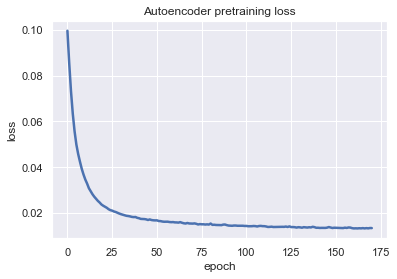

Iter:0 -> loss:0
Iter:140 -> loss:0.01871095411479473
Iter:280 -> loss:0.015731457620859146


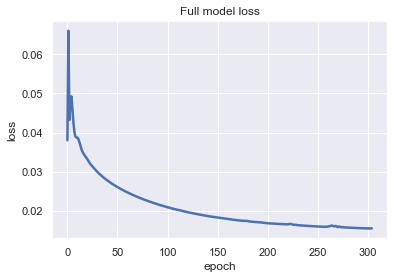

Training Done


In [ ]:
tf.get_logger().setLevel('ERROR')

dc = None
dc = DeepLatentCluster(
    'test-latent-all',
    {
        'train_size':0,
        'reconstr_weight':1.0,
        'latent_weight':1e-5,
        "cluster": None
    })
dc.make_model()
dc.train_model()

# Latent Head

## OPTICS

Autoencoder
Latent Model
model compiled
Loading AE weights from ./results/test-latent-all\ae_weights.h5
Loading model weights from ./results/test-latent-all\lat_model_final.h5
Using [z] head for predictions
Load Data 
Test Data Loaded (185490, 768)
Predicting...8 batches of 256 x 768


  0%|          | 0/8 [00:00<?, ?it/s]

Clustering 2000 points using OPTICS
Visualising
UMAP(metric='manhattan', verbose=True)
Sun Aug 28 18:10:53 2022 Construct fuzzy simplicial set
Sun Aug 28 18:10:56 2022 Finding Nearest Neighbors
Sun Aug 28 18:10:57 2022 Finished Nearest Neighbor Search
Sun Aug 28 18:10:59 2022 Construct embedding


Epochs completed:   0%|            0/500 [00:00]

Sun Aug 28 18:11:03 2022 Finished embedding
CLUSTERS
#PERCENT:0 size:5 prec:1.0000 rec:0.0746 f1:0.1389
#UNK-PERCENT-1:1 size:9 prec:1.0000 rec:0.0746 f1:0.1389
#MONEY:2 size:10 prec:1.0000 rec:0.2041 f1:0.3390
#QUANTITY:4 size:7 prec:1.0000 rec:0.0897 f1:0.1647
#UNK-QUANTITY-4:3 size:5 prec:1.0000 rec:0.0513 f1:0.0976
#UNK-MONEY-5:5 size:5 prec:1.0000 rec:0.1020 f1:0.1852
#PRODUCT:37 size:13 prec:1.0000 rec:0.1171 f1:0.2097
#TIME:11 size:5 prec:1.0000 rec:0.0667 f1:0.1250
#DATE:8 size:5 prec:1.0000 rec:0.5556 f1:0.7143
#UNK-PERCENT-9:9 size:7 prec:1.0000 rec:0.1045 f1:0.1892
#LAW:124 size:57 prec:1.0000 rec:0.5333 f1:0.6957
#UNK-TIME-11:7 size:6 prec:1.0000 rec:0.0533 f1:0.1013
#WORK_OF_ART:32 size:22 prec:1.0000 rec:0.1947 f1:0.3259
#EVENT:13 size:5 prec:1.0000 rec:0.0500 f1:0.0952
#UNK-PERCENT-14:14 size:7 prec:1.0000 rec:0.1045 f1:0.1892
#PERSON:68 size:5 prec:1.0000 rec:0.3571 f1:0.5263
#UNK-QUANTITY-16:16 size:7 prec:1.0000 rec:0.0897 f1:0.1647
#UNK-PERCENT-17:17 size:6 prec:1.00

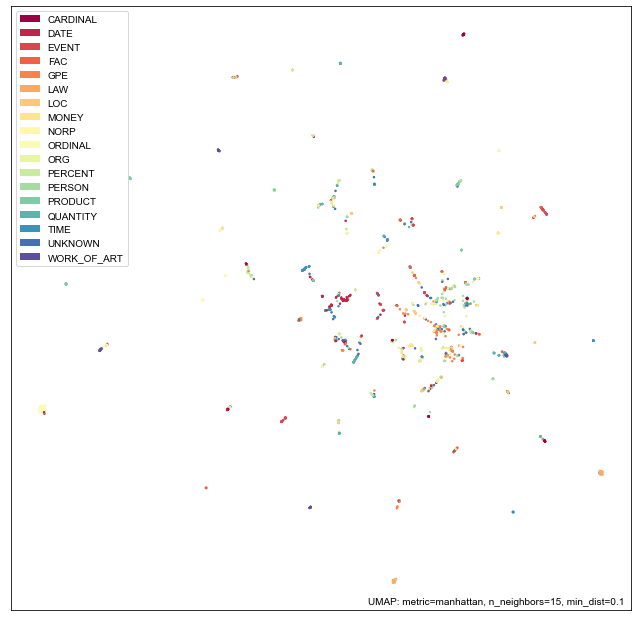

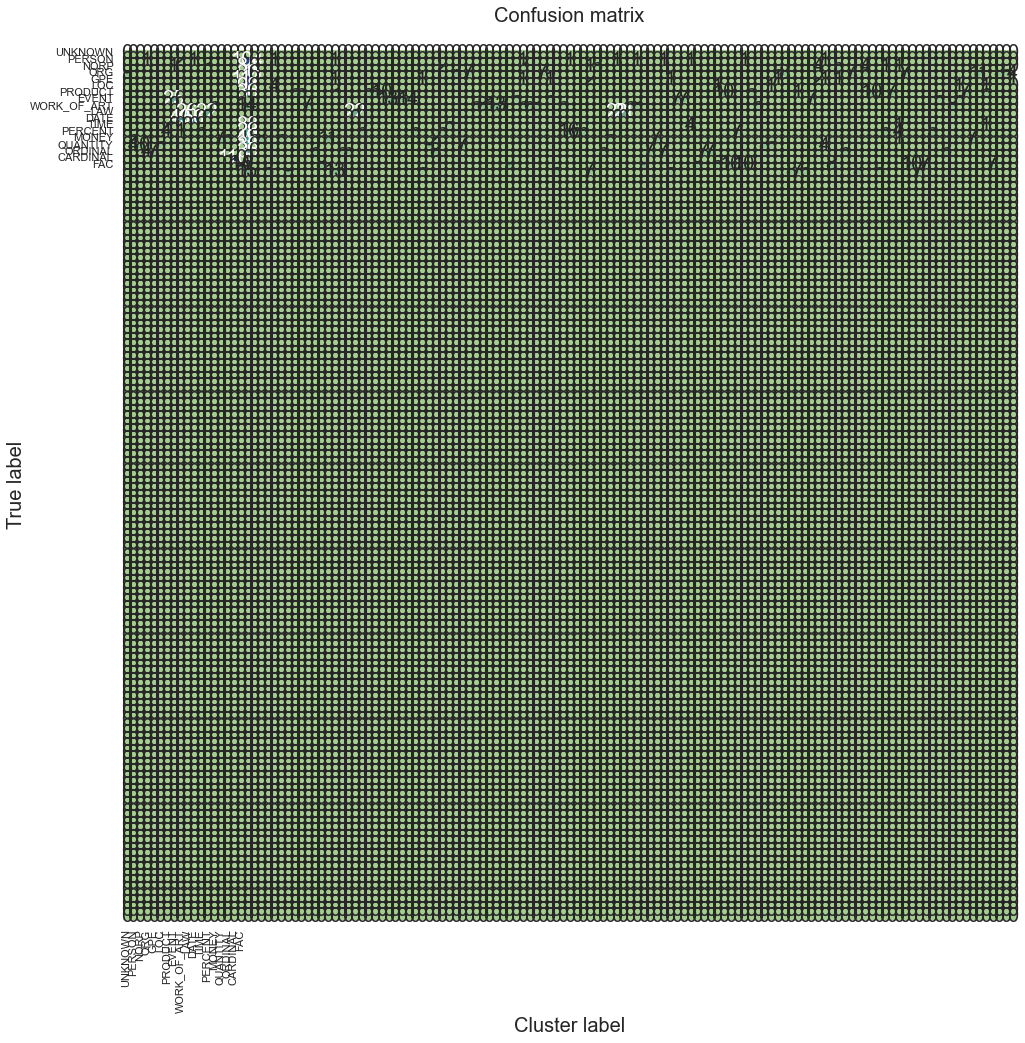



F1 score (macro) = 0.6806
Accuracy = 0.6575
Precision = 0.8971
Recall = 0.6567
... wrote results  <a href="c:\Users\Will\Projects\MSc\project\src\results\test-latent-all-OPTICS\index.html">c:\Users\Will\Projects\MSc\project\src\results\test-latent-all-OPTICS\index.html</a>


In [30]:
#%%time

dc = None
dc = DeepLatentCluster(
    'test-latent-all-OPTICS',
    {
        'train_size':0,
        'reconstr_weight':1.0,
        'latent_weight':1e-5,
        "cluster": "OPTICS"
    })

dc.evaluate_model('test-latent-all', sample_size=2000)

## Agglomerative Clustering

Autoencoder
Latent Model
model compiled
Loading AE weights from ./results/test-latent-all\ae_weights.h5
Loading model weights from ./results/test-latent-all\lat_model_final.h5
Using [z] head for predictions
Load Data 
Test Data Loaded (185490, 768)
Predicting...16 batches of 256 x 768


  0%|          | 0/16 [00:00<?, ?it/s]

Clustering 4000 points using agg
Visualising
UMAP(metric='manhattan', verbose=True)
Sun Aug 28 18:12:23 2022 Construct fuzzy simplicial set
Sun Aug 28 18:12:35 2022 Finding Nearest Neighbors
Sun Aug 28 18:12:35 2022 Finished Nearest Neighbor Search
Sun Aug 28 18:12:35 2022 Construct embedding


Epochs completed:   0%|            0/500 [00:00]

Sun Aug 28 18:12:41 2022 Finished embedding
CLUSTERS
#NORP:0 size:22 prec:1.0000 rec:0.4118 f1:0.5833
#ORG:1 size:4 prec:1.0000 rec:0.6000 f1:0.7500
#WORK_OF_ART:2 size:3734 prec:1.0000 rec:1.0000 f1:1.0000
#UNK-UNKNOWN-3:3 size:13 prec:0.6154 rec:0.0372 f1:0.0702
#EVENT:4 size:28 prec:1.0000 rec:1.0000 f1:1.0000
#UNK-NORP-5:5 size:23 prec:1.0000 rec:0.1765 f1:0.3000
#UNK-ORG-6:6 size:4 prec:1.0000 rec:0.4000 f1:0.5714
#DATE:7 size:3 prec:1.0000 rec:0.5000 f1:0.6667
#PRODUCT:8 size:36 prec:1.0000 rec:1.0000 f1:1.0000
#UNK-NORP-9:9 size:12 prec:1.0000 rec:0.1569 f1:0.2712
#LOC:24 size:21 prec:1.0000 rec:0.4348 f1:0.6061
#UNK-NORP-11:11 size:25 prec:1.0000 rec:0.2549 f1:0.4062
#UNK-UNKNOWN-12:12 size:2 prec:0.5000 rec:0.0047 f1:0.0092
#PERSON:13 size:4 prec:1.0000 rec:0.7500 f1:0.8571
#UNK-UNKNOWN-14:14 size:3 prec:0.6667 rec:0.0093 f1:0.0183
#UNK-DATE-15:15 size:1 prec:1.0000 rec:0.1667 f1:0.2857
#UNK-UNKNOWN-16:16 size:1 prec:1.0000 rec:0.0047 f1:0.0093
#UNK-UNKNOWN-17:17 size:1 prec:1

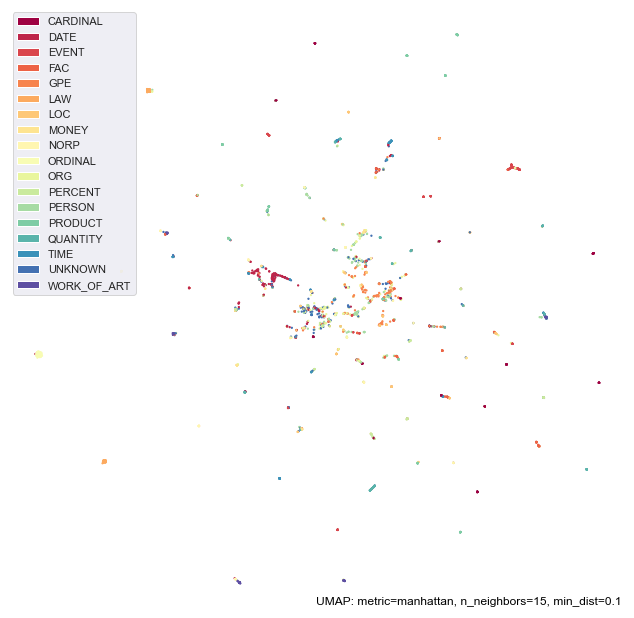

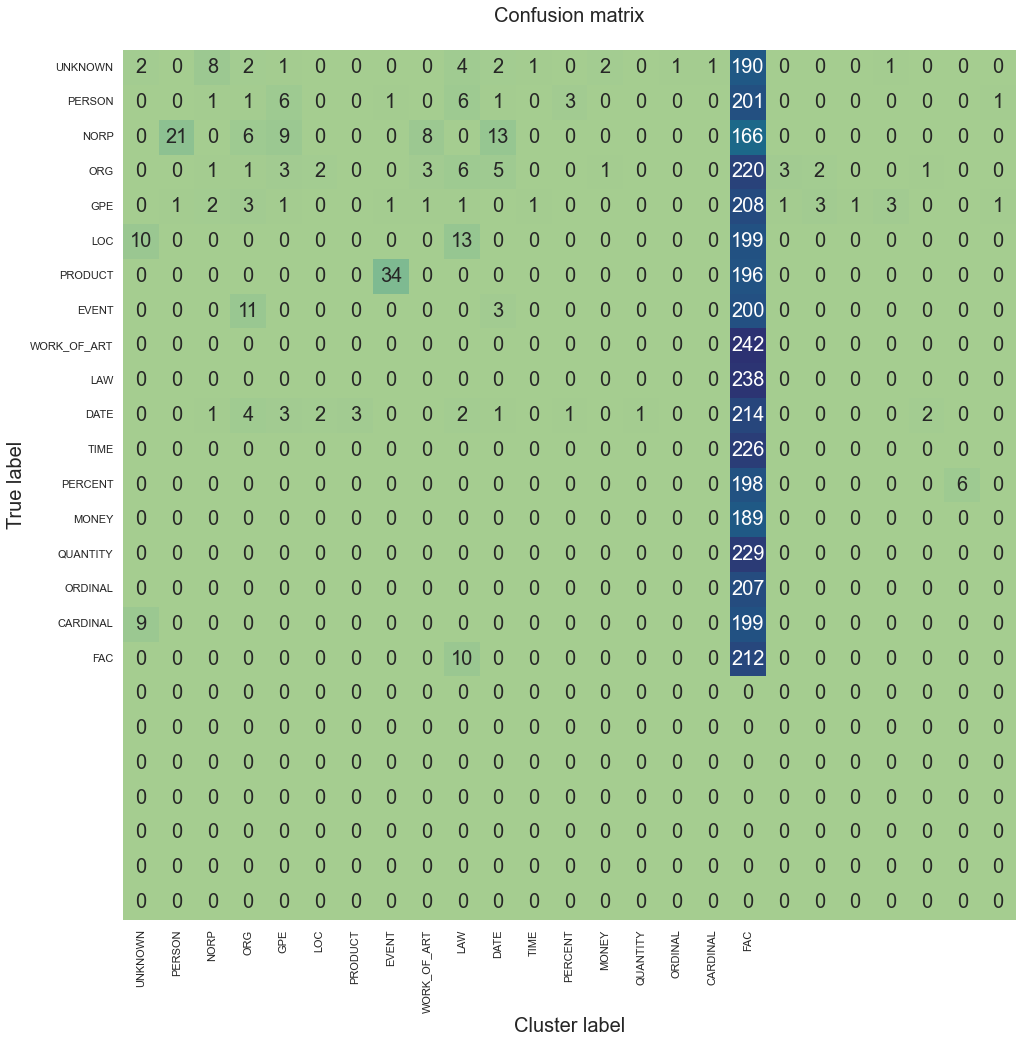



F1 score (macro) = 0.1261
Accuracy = 0.1510
Precision = 0.5589
Recall = 0.1475
... wrote results  <a href="c:\Users\Will\Projects\MSc\project\src\results\test-latent-all-agg\index.html">c:\Users\Will\Projects\MSc\project\src\results\test-latent-all-agg\index.html</a>
CPU times: total: 2min 6s
Wall time: 42.2 s


In [31]:
%%time

tf.get_logger().setLevel('ERROR')

dc = None
dc = DeepLatentCluster(
    'test-latent-all-agg',
    {
        'train_size':10000,
        'reconstr_weight':1.0,
        'latent_weight':1e-5,
        "cluster": "agg"
    })
# dc.make_model()
# dc.train_model()
dc.evaluate_model('test-latent-all', sample_size=4000)

## K-means

Autoencoder
Latent Model
model compiled
Loading AE weights from ./results/test-latent-all\ae_weights.h5
Loading model weights from ./results/test-latent-all\lat_model_final.h5
Using [z] head for predictions
Load Data 
Test Data Loaded (185490, 768)
Predicting...16 batches of 256 x 768


  0%|          | 0/16 [00:00<?, ?it/s]

Clustering 4000 points using Kmeans
Visualising
UMAP(metric='manhattan', verbose=True)
Sun Aug 28 18:13:05 2022 Construct fuzzy simplicial set
Sun Aug 28 18:13:16 2022 Finding Nearest Neighbors
Sun Aug 28 18:13:16 2022 Finished Nearest Neighbor Search
Sun Aug 28 18:13:16 2022 Construct embedding


Epochs completed:   0%|            0/500 [00:00]

Sun Aug 28 18:13:23 2022 Finished embedding
CLUSTERS
#DATE:0 size:240 prec:1.0000 rec:0.6744 f1:0.8056
#LOC:1 size:151 prec:1.0000 rec:1.0000 f1:1.0000
#GPE:2 size:324 prec:1.0000 rec:1.0000 f1:1.0000
#UNK-DATE-3:3 size:179 prec:1.0000 rec:0.3256 f1:0.4912
#ORDINAL:4 size:221 prec:1.0000 rec:1.0000 f1:1.0000
#LAW:8 size:129 prec:1.0000 rec:0.5167 f1:0.6813
#WORK_OF_ART:7 size:207 prec:1.0000 rec:0.4754 f1:0.6444
#UNK-WORK_OF_ART-7:6 size:173 prec:1.0000 rec:0.2951 f1:0.4557
#UNK-LAW-8:5 size:287 prec:1.0000 rec:0.4833 f1:0.6517
#MONEY:9 size:143 prec:1.0000 rec:0.3382 f1:0.5055
#ORG:10 size:87 prec:1.0000 rec:1.0000 f1:1.0000
#PRODUCT:11 size:122 prec:1.0000 rec:0.5207 f1:0.6848
#NORP:12 size:27 prec:1.0000 rec:0.2927 f1:0.4528
#UNK-WORK_OF_ART-13:13 size:110 prec:1.0000 rec:0.2295 f1:0.3733
#PERCENT:14 size:193 prec:1.0000 rec:1.0000 f1:1.0000
#TIME:15 size:227 prec:1.0000 rec:1.0000 f1:1.0000
#EVENT:16 size:193 prec:1.0000 rec:1.0000 f1:1.0000
#UNK-NORP-17:17 size:130 prec:1.0000 rec

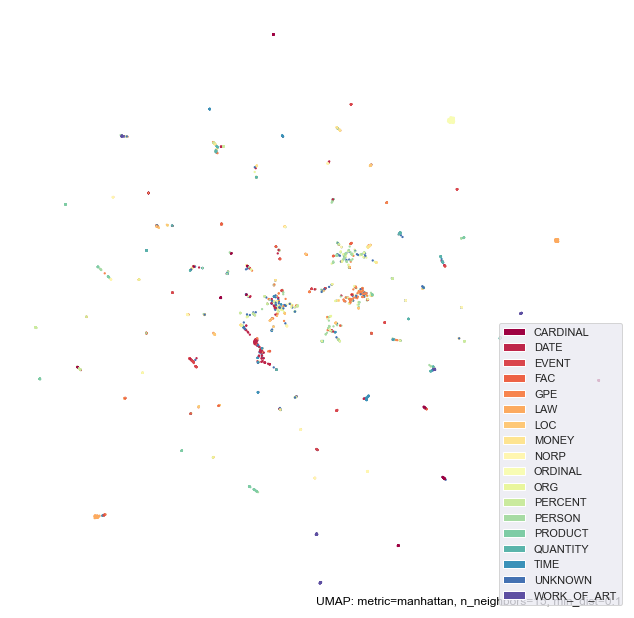

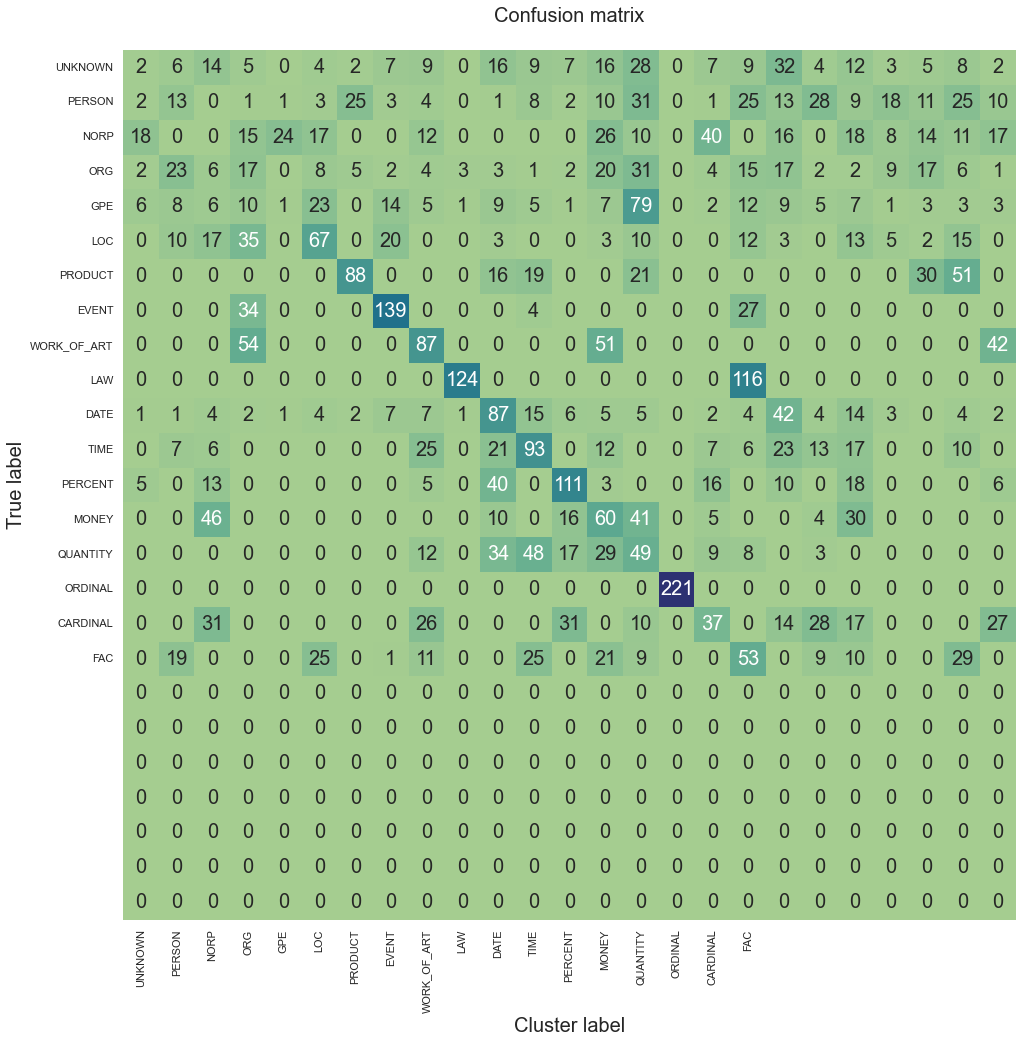



F1 score (macro) = 0.5261
Accuracy = 0.4813
Precision = 0.7828
Recall = 0.4788
... wrote results  <a href="c:\Users\Will\Projects\MSc\project\src\results\test-latent-all-Kmeans\index.html">c:\Users\Will\Projects\MSc\project\src\results\test-latent-all-Kmeans\index.html</a>
CPU times: total: 2min 45s
Wall time: 47.8 s


In [32]:
%%time

dc = None
dc = DeepLatentCluster(
    'test-latent-all-Kmeans',
    {
        'train_size':0,
        'reconstr_weight':1.0,
        'latent_weight':1e-5,
        "cluster": "Kmeans"
    })
# dc.make_model()
# dc.train_model()
dc.evaluate_model('test-latent-all', sample_size=4000)

## GMM

Autoencoder
Latent Model
model compiled
Loading AE weights from ./results/test-latent-all\ae_weights.h5
Loading model weights from ./results/test-latent-all\lat_model_final.h5
Using [z] head for predictions
Load Data 
Test Data Loaded (185490, 768)
Predicting...16 batches of 256 x 768


  0%|          | 0/16 [00:00<?, ?it/s]

Clustering 4000 points using GMM
Initialization 0
  Iteration 10	 time lapse 98.42640s	 ll change 0.19984
  Iteration 20	 time lapse 86.82295s	 ll change 0.09333
  Iteration 30	 time lapse 84.23669s	 ll change 0.08251
Initialization converged: True	 time lapse 286.30849s	 ll 11839.04510
Visualising
UMAP(metric='manhattan', verbose=True)
Sun Aug 28 18:18:53 2022 Construct fuzzy simplicial set
Sun Aug 28 18:19:05 2022 Finding Nearest Neighbors
Sun Aug 28 18:19:05 2022 Finished Nearest Neighbor Search
Sun Aug 28 18:19:05 2022 Construct embedding


Epochs completed:   0%|            0/500 [00:00]

Sun Aug 28 18:19:11 2022 Finished embedding
CLUSTERS
#GPE:0 size:488 prec:1.0000 rec:1.0000 f1:1.0000
#ORDINAL:1 size:202 prec:1.0000 rec:1.0000 f1:1.0000
#PERCENT:19 size:210 prec:1.0000 rec:0.5273 f1:0.6905
#WORK_OF_ART:7 size:119 prec:1.0000 rec:0.3662 f1:0.5361
#MONEY:18 size:38 prec:1.0000 rec:0.1329 f1:0.2346
#LAW:13 size:114 prec:1.0000 rec:0.4888 f1:0.6566
#PERSON:6 size:72 prec:1.0000 rec:0.3562 f1:0.5253
#UNK-WORK_OF_ART-7:3 size:143 prec:1.0000 rec:0.3028 f1:0.4649
#LOC:8 size:146 prec:1.0000 rec:1.0000 f1:1.0000
#TIME:9 size:234 prec:1.0000 rec:1.0000 f1:1.0000
#PRODUCT:10 size:37 prec:1.0000 rec:0.2303 f1:0.3743
#UNK-PERSON-11:11 size:171 prec:1.0000 rec:0.6438 f1:0.7833
#EVENT:23 size:130 prec:1.0000 rec:0.5133 f1:0.6784
#UNK-LAW-13:5 size:249 prec:1.0000 rec:0.5112 f1:0.6766
#NORP:14 size:16 prec:1.0000 rec:0.3077 f1:0.4706
#UNK-PRODUCT-15:15 size:188 prec:1.0000 rec:0.7697 f1:0.8699
#UNK-WORK_OF_ART-16:16 size:139 prec:1.0000 rec:0.3310 f1:0.4974
#CARDINAL:17 size:129 p

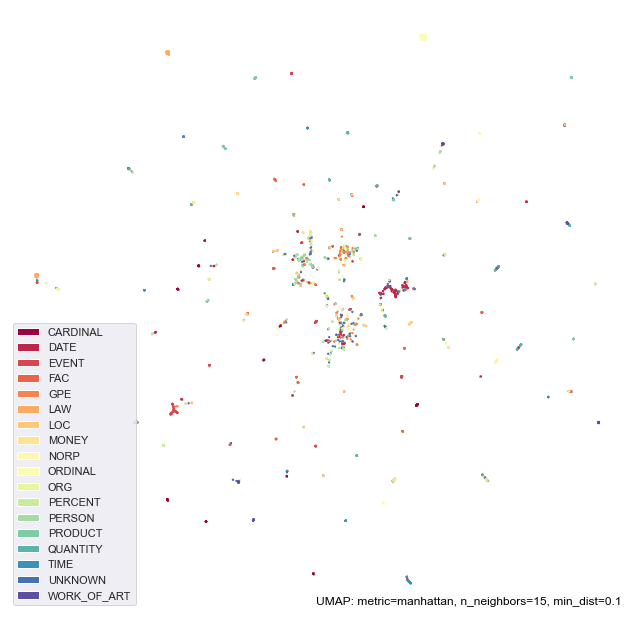

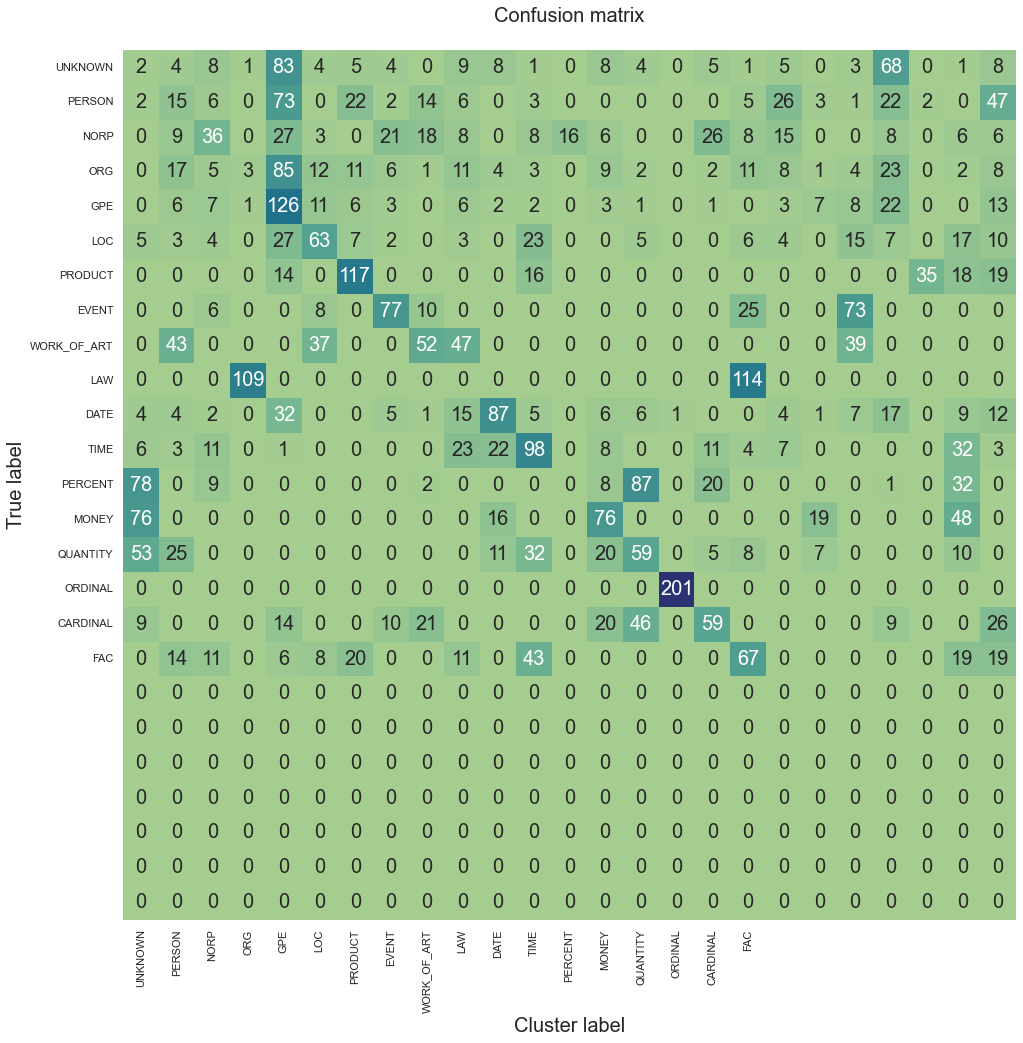



F1 score (macro) = 0.5476
Accuracy = 0.4915
Precision = 0.7835
Recall = 0.4945
... wrote results  <a href="c:\Users\Will\Projects\MSc\project\src\results\test-latent-all-GMM\index.html">c:\Users\Will\Projects\MSc\project\src\results\test-latent-all-GMM\index.html</a>
CPU times: total: 42min 22s
Wall time: 5min 46s


In [33]:
%%time

dc = None
dc = DeepLatentCluster(
    'test-latent-all-GMM',
    {
        'train_size':0,
        'reconstr_weight':1.0,
        'latent_weight':1e-5,
        "cluster": "GMM"
    })
# dc.make_model()
# dc.train_model()
dc.evaluate_model('test-latent-all', sample_size=4000)

# Encoder Head

Autoencoder
Latent Model
model compiled
Loading AE weights from ./results/test-latent-all\ae_weights.h5
Loading model weights from ./results/test-latent-all\lat_model_final.h5
Using [enc] head for predictions
Load Data 
Test Data Loaded (185490, 768)
Predicting...12 batches of 256 x 768


  0%|          | 0/12 [00:00<?, ?it/s]

Clustering 3000 points using OPTICS
Visualising
UMAP(metric='manhattan', verbose=True)
Sun Aug 28 18:22:47 2022 Construct fuzzy simplicial set
Sun Aug 28 18:22:49 2022 Finding Nearest Neighbors
Sun Aug 28 18:22:49 2022 Finished Nearest Neighbor Search
Sun Aug 28 18:22:49 2022 Construct embedding


Epochs completed:   0%|            0/500 [00:00]

Sun Aug 28 18:22:54 2022 Finished embedding
CLUSTERS
#GPE:0 size:5 prec:1.0000 rec:0.1562 f1:0.2703
#PRODUCT:27 size:12 prec:1.0000 rec:0.0741 f1:0.1379
#UNK-GPE-2:2 size:7 prec:1.0000 rec:0.1875 f1:0.3158
#UNK-GPE-3:3 size:9 prec:1.0000 rec:0.2812 f1:0.4390
#LOC:4 size:7 prec:1.0000 rec:0.0588 f1:0.1111
#QUANTITY:5 size:6 prec:1.0000 rec:0.0392 f1:0.0755
#UNK-QUANTITY-6:6 size:5 prec:1.0000 rec:0.0327 f1:0.0633
#MONEY:7 size:10 prec:1.0000 rec:0.0719 f1:0.1342
#UNK-QUANTITY-8:8 size:5 prec:1.0000 rec:0.0327 f1:0.0633
#UNK-QUANTITY-9:9 size:8 prec:1.0000 rec:0.0523 f1:0.0994
#UNK-MONEY-10:10 size:7 prec:1.0000 rec:0.0504 f1:0.0959
#UNK-MONEY-11:11 size:12 prec:1.0000 rec:0.0863 f1:0.1589
#UNK-MONEY-12:12 size:6 prec:1.0000 rec:0.0360 f1:0.0694
#UNK-MONEY-13:13 size:10 prec:1.0000 rec:0.0647 f1:0.1216
#UNK-MONEY-14:14 size:5 prec:1.0000 rec:0.0360 f1:0.0694
#UNK-QUANTITY-15:15 size:8 prec:1.0000 rec:0.0523 f1:0.0994
#PERCENT:16 size:5 prec:1.0000 rec:0.0362 f1:0.0699
#WORK_OF_ART:17 siz

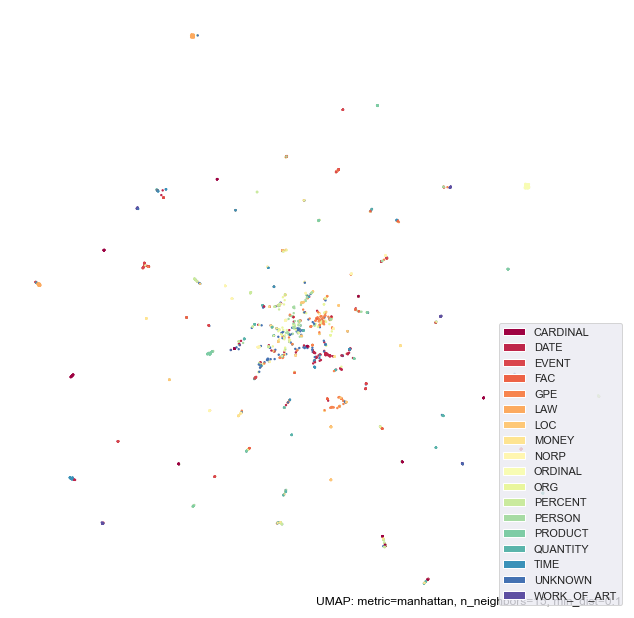

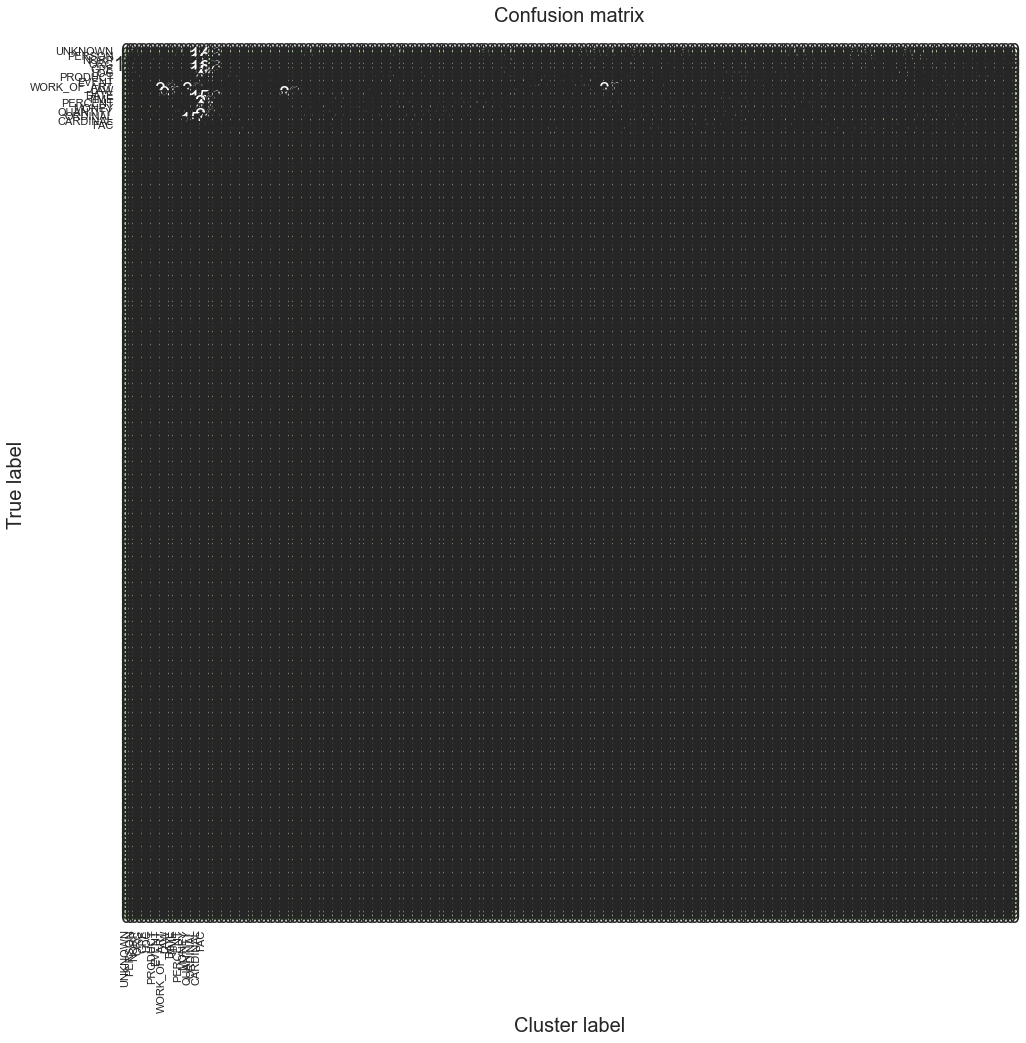



F1 score (macro) = 0.7378
Accuracy = 0.7310
Precision = 0.9537
Recall = 0.7333
... wrote results  <a href="c:\Users\Will\Projects\MSc\project\src\results\test-latent-all-OPTICS-Enc-2\index.html">c:\Users\Will\Projects\MSc\project\src\results\test-latent-all-OPTICS-Enc-2\index.html</a>
CPU times: total: 1h 9min 33s
Wall time: 5min 34s


In [34]:
%%time
#min cluster size

dc = None
dc = DeepLatentCluster(
    'test-latent-all-OPTICS-Enc-2',
    {
        'train_size':0,
        'reconstr_weight':1.0,
        'latent_weight':1e-5,
        "cluster": "OPTICS"
    })

dc.evaluate_model('test-latent-all', head="enc", sample_size=3000)

## Optics-Encoder

Autoencoder
Latent Model
model compiled
Loading AE weights from ./results/test-latent-all\ae_weights.h5
Loading model weights from ./results/test-latent-all\lat_model_final.h5
Using [enc] head for predictions
Load Data 
Test Data Loaded (185490, 768)
Predicting...12 batches of 256 x 768


  0%|          | 0/12 [00:00<?, ?it/s]

Clustering 3000 points using OPTICS
Visualising
UMAP(metric='manhattan', verbose=True)
Sun Aug 28 18:28:20 2022 Construct fuzzy simplicial set
Sun Aug 28 18:28:23 2022 Finding Nearest Neighbors
Sun Aug 28 18:28:23 2022 Finished Nearest Neighbor Search
Sun Aug 28 18:28:23 2022 Construct embedding


Epochs completed:   0%|            0/500 [00:00]

Sun Aug 28 18:28:29 2022 Finished embedding
CLUSTERS
#MONEY:0 size:6 prec:1.0000 rec:0.0331 f1:0.0642
#FAC:1 size:6 prec:1.0000 rec:0.0472 f1:0.0902
#LAW:179 size:83 prec:1.0000 rec:0.4826 f1:0.6510
#EVENT:3 size:6 prec:1.0000 rec:0.0397 f1:0.0764
#PRODUCT:25 size:15 prec:1.0000 rec:0.0794 f1:0.1471
#GPE:5 size:8 prec:1.0000 rec:0.3077 f1:0.4706
#UNK-GPE-6:6 size:5 prec:1.0000 rec:0.1923 f1:0.3226
#UNK-GPE-7:7 size:5 prec:1.0000 rec:0.1923 f1:0.3226
#UNK-FAC-8:8 size:9 prec:1.0000 rec:0.0709 f1:0.1324
#DATE:10 size:7 prec:1.0000 rec:0.4375 f1:0.6087
#UNK-DATE-10:9 size:5 prec:1.0000 rec:0.2500 f1:0.4000
#QUANTITY:12 size:8 prec:1.0000 rec:0.0615 f1:0.1159
#UNK-QUANTITY-12:11 size:8 prec:1.0000 rec:0.0538 f1:0.1022
#UNK-QUANTITY-13:13 size:9 prec:1.0000 rec:0.0692 f1:0.1295
#UNK-QUANTITY-14:14 size:5 prec:1.0000 rec:0.0385 f1:0.0741
#UNK-QUANTITY-15:15 size:14 prec:1.0000 rec:0.1077 f1:0.1944
#UNK-MONEY-16:16 size:8 prec:1.0000 rec:0.0442 f1:0.0847
#UNK-MONEY-17:17 size:10 prec:1.0000 r

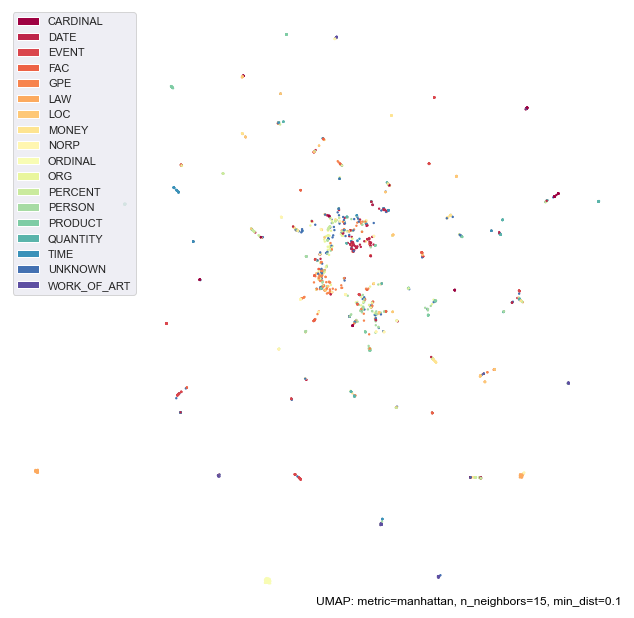

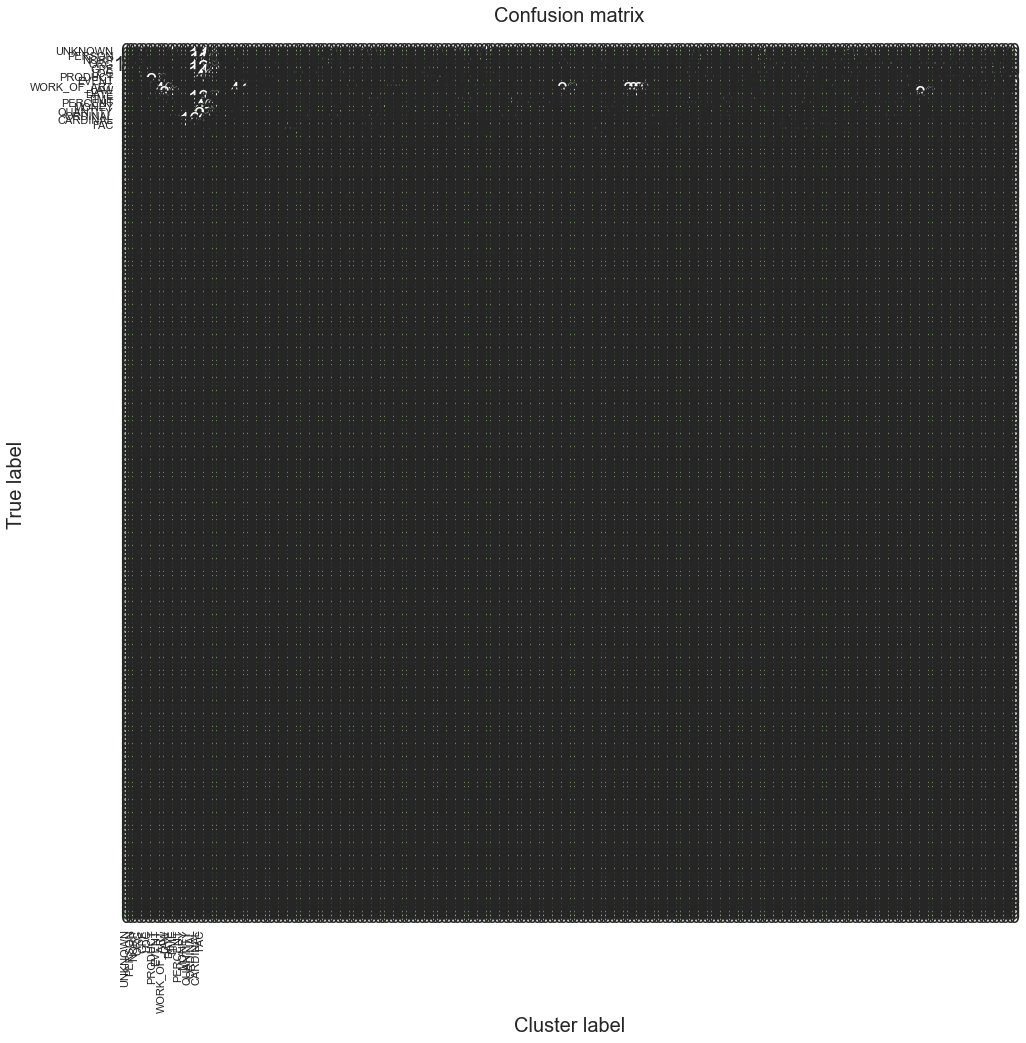



F1 score (macro) = 0.7454
Accuracy = 0.7407
Precision = 0.9543
Recall = 0.7353
... wrote results  <a href="c:\Users\Will\Projects\MSc\project\src\results\test-latent-all-OPTICS-Enc\index.html">c:\Users\Will\Projects\MSc\project\src\results\test-latent-all-OPTICS-Enc\index.html</a>
CPU times: total: 1h 11min 46s
Wall time: 5min 30s


In [35]:
%%time

dc = None
dc = DeepLatentCluster(
    'test-latent-all-OPTICS-Enc',
    {
        'train_size':0,
        'reconstr_weight':1.0,
        'latent_weight':1e-5,
        "cluster": "OPTICS"
    })

dc.evaluate_model('test-latent-all', head="enc", sample_size=3000)

## Agglomerative-Encoder

Autoencoder
Latent Model
model compiled
Loading AE weights from ./results/test-latent-all\ae_weights.h5
Loading model weights from ./results/test-latent-all\lat_model_final.h5
Using [enc] head for predictions
Load Data 
Test Data Loaded (185490, 768)
Predicting...16 batches of 256 x 768


  0%|          | 0/16 [00:00<?, ?it/s]

Clustering 4000 points using agg
Visualising
UMAP(metric='manhattan', verbose=True)
Sun Aug 28 18:30:40 2022 Construct fuzzy simplicial set
Sun Aug 28 18:30:44 2022 Finding Nearest Neighbors
Sun Aug 28 18:30:44 2022 Finished Nearest Neighbor Search
Sun Aug 28 18:30:44 2022 Construct embedding


Epochs completed:   0%|            0/500 [00:00]

Sun Aug 28 18:30:50 2022 Finished embedding
CLUSTERS
#PRODUCT:0 size:43 prec:1.0000 rec:1.0000 f1:1.0000
#MONEY:1 size:3714 prec:1.0000 rec:1.0000 f1:1.0000
#TIME:2 size:17 prec:1.0000 rec:1.0000 f1:1.0000
#NORP:15 size:8 prec:1.0000 rec:0.1194 f1:0.2133
#PERSON:17 size:1 prec:1.0000 rec:0.1000 f1:0.1818
#UNK-NORP-5:5 size:29 prec:1.0000 rec:0.2388 f1:0.3855
#GPE:6 size:5 prec:1.0000 rec:0.1905 f1:0.3200
#ORG:16 size:2 prec:1.0000 rec:0.2500 f1:0.4000
#DATE:8 size:2 prec:1.0000 rec:1.0000 f1:1.0000
#UNK-GPE-9:9 size:6 prec:1.0000 rec:0.1429 f1:0.2500
#UNK-GPE-10:10 size:31 prec:1.0000 rec:0.3810 f1:0.5517
#UNK-GPE-11:11 size:4 prec:1.0000 rec:0.1429 f1:0.2500
#UNK-UNKNOWN-12:12 size:1 prec:1.0000 rec:0.0045 f1:0.0090
#PERCENT:13 size:2 prec:1.0000 rec:1.0000 f1:1.0000
#CARDINAL:14 size:36 prec:1.0000 rec:1.0000 f1:1.0000
#UNK-NORP-15:3 size:28 prec:1.0000 rec:0.3731 f1:0.5435
#UNK-ORG-16:7 size:6 prec:1.0000 rec:0.5000 f1:0.6667
#UNK-PERSON-17:4 size:21 prec:1.0000 rec:0.9000 f1:0.9474

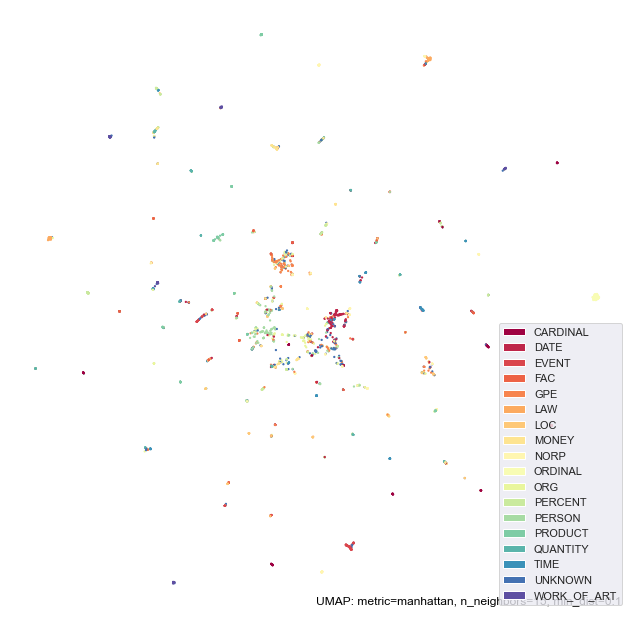

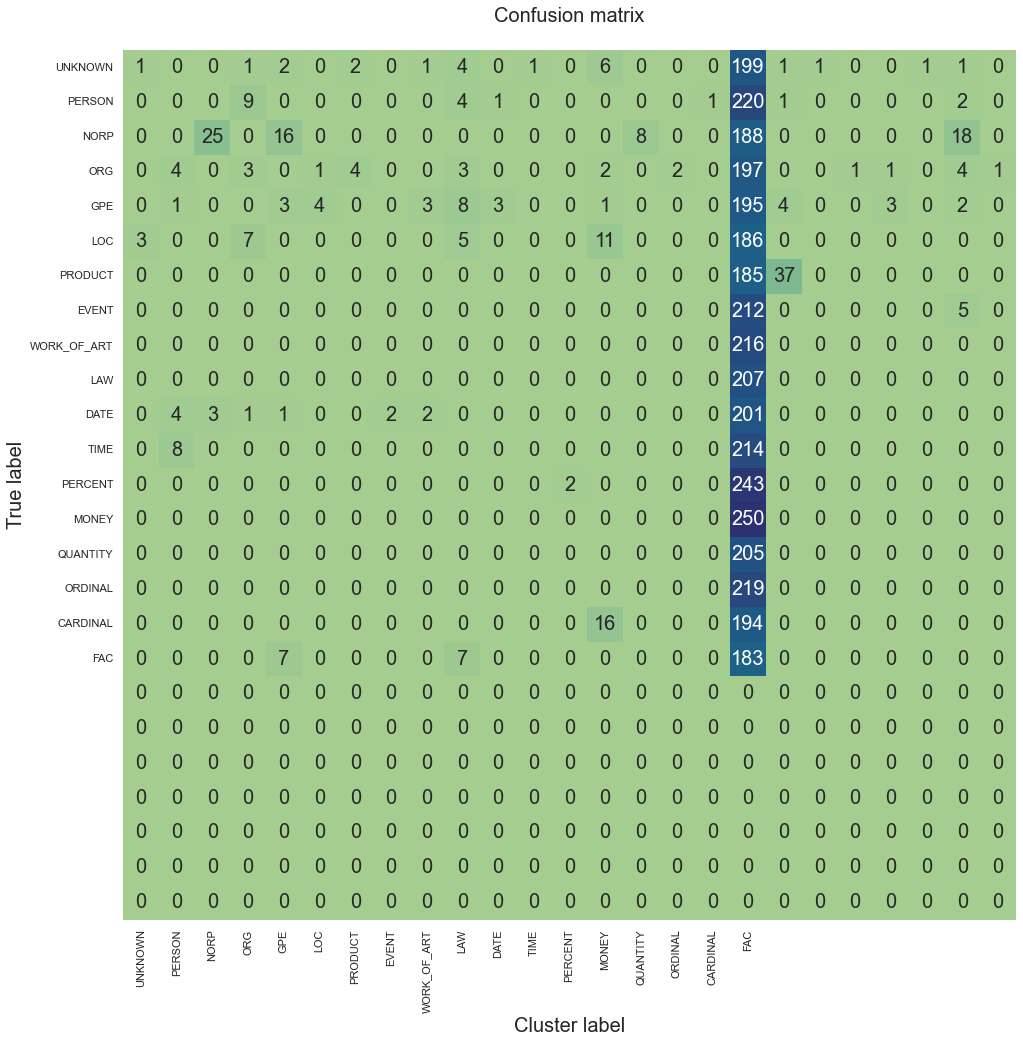



F1 score (macro) = 0.1340
Accuracy = 0.1613
Precision = 0.6145
Recall = 0.1524
... wrote results  <a href="c:\Users\Will\Projects\MSc\project\src\results\test-latent-all-agg-enc\index.html">c:\Users\Will\Projects\MSc\project\src\results\test-latent-all-agg-enc\index.html</a>
CPU times: total: 1min 44s
Wall time: 28.4 s


In [36]:
%%time

dc = None
dc = DeepLatentCluster(
    'test-latent-all-agg-enc',
    {
        'train_size':0,
        'reconstr_weight':1.0,
        'latent_weight':1e-5,
        "cluster": "agg"
    })
# dc.make_model()
# dc.train_model()
dc.evaluate_model('test-latent-all', head='enc',  sample_size=4000)

## KMeans-Encoder

Autoencoder
Latent Model
model compiled
Loading AE weights from ./results/test-latent-all\ae_weights.h5
Loading model weights from ./results/test-latent-all\lat_model_final.h5
Using [enc] head for predictions
Load Data 
Test Data Loaded (185490, 768)
Predicting...16 batches of 256 x 768


  0%|          | 0/16 [00:00<?, ?it/s]

Clustering 4000 points using Kmeans
Visualising
UMAP(metric='manhattan', verbose=True)
Sun Aug 28 18:31:09 2022 Construct fuzzy simplicial set
Sun Aug 28 18:31:13 2022 Finding Nearest Neighbors
Sun Aug 28 18:31:13 2022 Finished Nearest Neighbor Search
Sun Aug 28 18:31:13 2022 Construct embedding


Epochs completed:   0%|            0/500 [00:00]

Sun Aug 28 18:31:20 2022 Finished embedding
CLUSTERS
#EVENT:0 size:157 prec:1.0000 rec:1.0000 f1:1.0000
#PERSON:1 size:148 prec:1.0000 rec:1.0000 f1:1.0000
#LOC:2 size:83 prec:1.0000 rec:1.0000 f1:1.0000
#PERCENT:3 size:318 prec:1.0000 rec:1.0000 f1:1.0000
#CARDINAL:14 size:86 prec:1.0000 rec:0.5520 f1:0.7113
#LAW:15 size:118 prec:1.0000 rec:0.4739 f1:0.6431
#ORDINAL:6 size:203 prec:1.0000 rec:1.0000 f1:1.0000
#WORK_OF_ART:18 size:197 prec:1.0000 rec:0.5326 f1:0.6950
#NORP:8 size:21 prec:1.0000 rec:0.1750 f1:0.2979
#UNK-NORP-9:9 size:187 prec:1.0000 rec:0.2917 f1:0.4516
#DATE:10 size:341 prec:1.0000 rec:1.0000 f1:1.0000
#MONEY:11 size:367 prec:1.0000 rec:1.0000 f1:1.0000
#FAC:17 size:40 prec:1.0000 rec:0.1293 f1:0.2290
#UNK-WORK_OF_ART-13:7 size:165 prec:1.0000 rec:0.2609 f1:0.4138
#UNK-CARDINAL-14:4 size:94 prec:1.0000 rec:0.3040 f1:0.4663
#UNK-LAW-15:5 size:230 prec:1.0000 rec:0.5261 f1:0.6895
#PRODUCT:20 size:33 prec:1.0000 rec:0.2183 f1:0.3584
#UNK-FAC-17:12 size:435 prec:1.0000 re

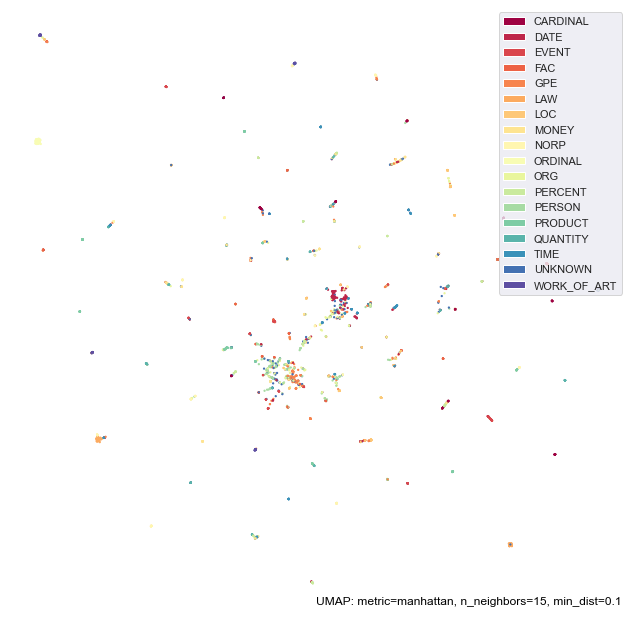

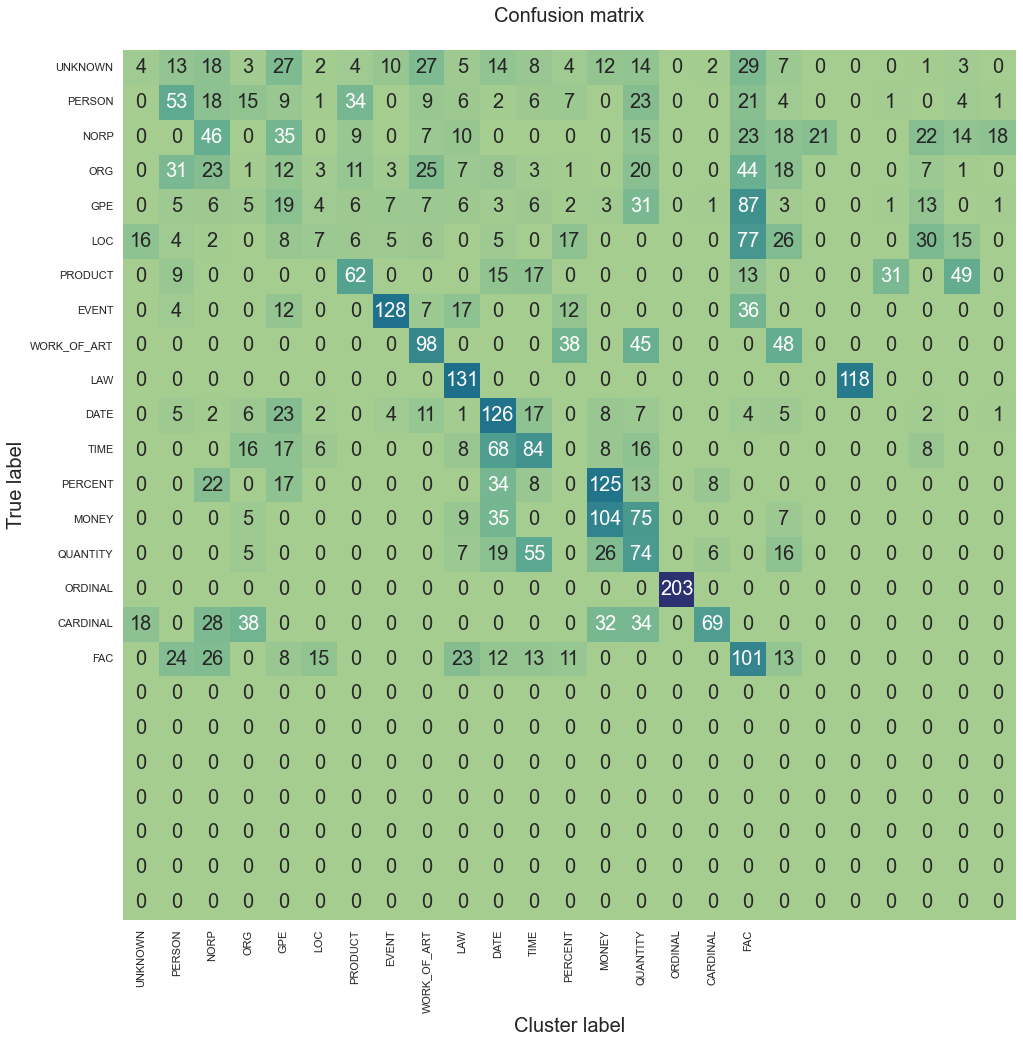



F1 score (macro) = 0.5424
Accuracy = 0.4918
Precision = 0.7829
Recall = 0.4914
... wrote results  <a href="c:\Users\Will\Projects\MSc\project\src\results\test-latent-all-Kmeans-Enc\index.html">c:\Users\Will\Projects\MSc\project\src\results\test-latent-all-Kmeans-Enc\index.html</a>
CPU times: total: 2min 18s
Wall time: 34.8 s


In [37]:
%%time

dc = None
dc = DeepLatentCluster(
    'test-latent-all-Kmeans-Enc',
    {
        'train_size':0,
        'reconstr_weight':1.0,
        'latent_weight':1e-5,
        "cluster": "Kmeans"
    })

dc.evaluate_model('test-latent-all', head="enc", sample_size=4000)

## GMM-Encoder

Autoencoder
Latent Model
model compiled
Loading AE weights from ./results/test-latent-all\ae_weights.h5
Loading model weights from ./results/test-latent-all\lat_model_final.h5
Using [enc] head for predictions
Load Data 
Test Data Loaded (185490, 768)
Predicting...16 batches of 256 x 768


  0%|          | 0/16 [00:00<?, ?it/s]

Clustering 4000 points using GMM
Initialization 0
  Iteration 10	 time lapse 0.77427s	 ll change 0.45709
  Iteration 20	 time lapse 0.61912s	 ll change 0.22488
  Iteration 30	 time lapse 0.57768s	 ll change 0.01886
  Iteration 40	 time lapse 0.60121s	 ll change 0.00000
Initialization converged: True	 time lapse 2.57227s	 ll 58.04226
Visualising
UMAP(metric='manhattan', verbose=True)
Sun Aug 28 18:31:45 2022 Construct fuzzy simplicial set
Sun Aug 28 18:31:50 2022 Finding Nearest Neighbors
Sun Aug 28 18:31:50 2022 Finished Nearest Neighbor Search
Sun Aug 28 18:31:50 2022 Construct embedding


Epochs completed:   0%|            0/500 [00:00]

Sun Aug 28 18:31:56 2022 Finished embedding
CLUSTERS
#TIME:18 size:164 prec:1.0000 rec:0.5130 f1:0.6781
#MONEY:1 size:261 prec:1.0000 rec:1.0000 f1:1.0000
#GPE:2 size:258 prec:1.0000 rec:1.0000 f1:1.0000
#PRODUCT:23 size:28 prec:1.0000 rec:0.1677 f1:0.2872
#DATE:4 size:636 prec:1.0000 rec:1.0000 f1:1.0000
#FAC:5 size:79 prec:1.0000 rec:0.3838 f1:0.5547
#LAW:6 size:126 prec:1.0000 rec:0.5066 f1:0.6725
#EVENT:7 size:138 prec:1.0000 rec:1.0000 f1:1.0000
#PERSON:8 size:104 prec:1.0000 rec:1.0000 f1:1.0000
#ORDINAL:9 size:219 prec:1.0000 rec:1.0000 f1:1.0000
#LOC:10 size:101 prec:1.0000 rec:1.0000 f1:1.0000
#NORP:24 size:15 prec:1.0000 rec:0.2083 f1:0.3448
#UNK-LAW-12:12 size:213 prec:1.0000 rec:0.4934 f1:0.6608
#ORG:13 size:72 prec:1.0000 rec:1.0000 f1:1.0000
#PERCENT:14 size:192 prec:1.0000 rec:1.0000 f1:1.0000
#CARDINAL:22 size:197 prec:1.0000 rec:0.8409 f1:0.9136
#WORK_OF_ART:16 size:252 prec:1.0000 rec:1.0000 f1:1.0000
#UNK-NORP-17:17 size:98 prec:1.0000 rec:0.3472 f1:0.5155
#UNK-TIME-

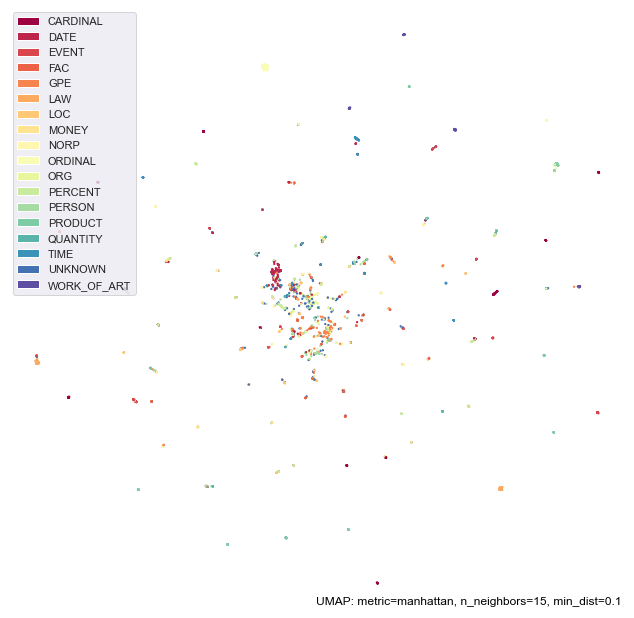

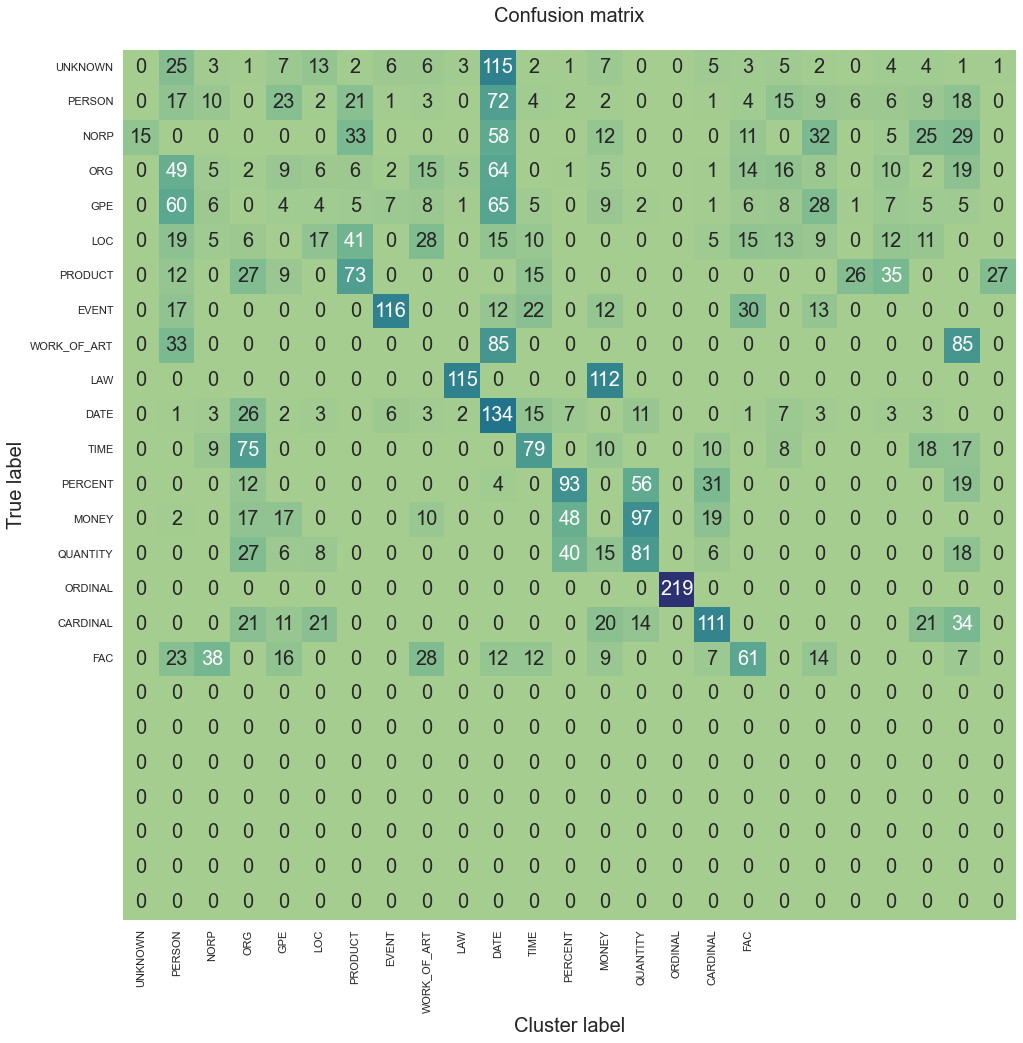



F1 score (macro) = 0.5449
Accuracy = 0.4830
Precision = 0.8941
Recall = 0.4812
... wrote results  <a href="c:\Users\Will\Projects\MSc\project\src\results\test-latent-all-GMM-Enc\index.html">c:\Users\Will\Projects\MSc\project\src\results\test-latent-all-GMM-Enc\index.html</a>
CPU times: total: 2min 7s
Wall time: 36.3 s


In [38]:
%%time

dc = None
dc = DeepLatentCluster(
    'test-latent-all-GMM-Enc',
    {
        'train_size':0,
        'reconstr_weight':1.0,
        'latent_weight':1e-5,
        "cluster": "GMM"
    })

dc.evaluate_model('test-latent-all', head="enc", sample_size=4000)

# Decoder Head


## Optics-AE

Autoencoder
Latent Model
model compiled
Loading AE weights from ./results/test-latent-all\ae_weights.h5
Loading model weights from ./results/test-latent-all\lat_model_final.h5
Using [ae] head for predictions
Load Data 
Test Data Loaded (185490, 768)
Predicting...12 batches of 256 x 768


  0%|          | 0/12 [00:00<?, ?it/s]

Clustering 3000 points using OPTICS
Visualising
UMAP(metric='manhattan', verbose=True)
Sun Aug 28 18:35:47 2022 Construct fuzzy simplicial set
Sun Aug 28 18:35:51 2022 Finding Nearest Neighbors
Sun Aug 28 18:35:51 2022 Finished Nearest Neighbor Search
Sun Aug 28 18:35:51 2022 Construct embedding


Epochs completed:   0%|            0/500 [00:00]

Sun Aug 28 18:35:56 2022 Finished embedding
CLUSTERS
#PRODUCT:0 size:25 prec:1.0000 rec:0.1572 f1:0.2717
#EVENT:26 size:5 prec:1.0000 rec:0.0347 f1:0.0671
#FAC:2 size:7 prec:1.0000 rec:0.0464 f1:0.0886
#WORK_OF_ART:29 size:30 prec:1.0000 rec:0.1887 f1:0.3175
#PERCENT:4 size:8 prec:1.0000 rec:0.0620 f1:0.1168
#TIME:5 size:9 prec:1.0000 rec:0.0604 f1:0.1139
#CARDINAL:6 size:13 prec:1.0000 rec:0.0798 f1:0.1477
#MONEY:7 size:8 prec:1.0000 rec:0.0523 f1:0.0994
#QUANTITY:8 size:6 prec:1.0000 rec:0.0420 f1:0.0805
#UNK-PERCENT-9:9 size:6 prec:1.0000 rec:0.0465 f1:0.0889
#UNK-PERCENT-10:10 size:9 prec:1.0000 rec:0.0698 f1:0.1304
#UNK-MONEY-11:11 size:5 prec:1.0000 rec:0.0327 f1:0.0633
#UNK-PERCENT-12:12 size:13 prec:1.0000 rec:0.1008 f1:0.1831
#UNK-PERCENT-13:13 size:5 prec:1.0000 rec:0.0388 f1:0.0746
#UNK-PERCENT-14:14 size:8 prec:1.0000 rec:0.0620 f1:0.1168
#UNK-PERCENT-15:15 size:7 prec:1.0000 rec:0.0543 f1:0.1029
#UNK-PERCENT-16:16 size:5 prec:1.0000 rec:0.0388 f1:0.0746
#UNK-QUANTITY-17:17

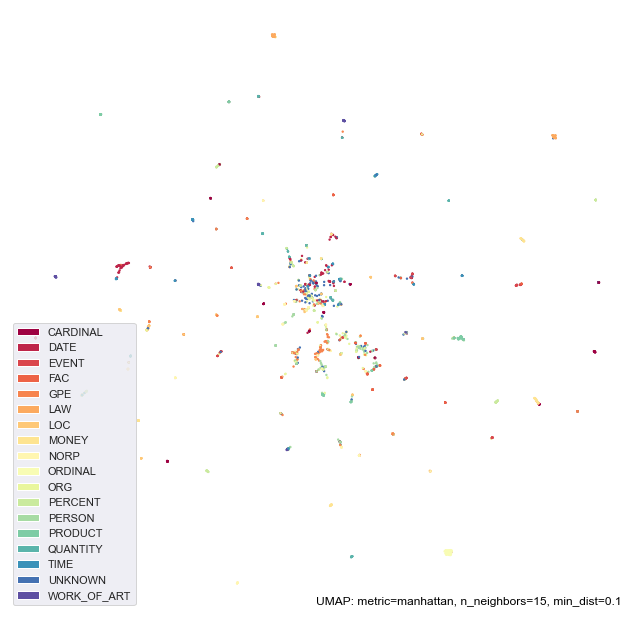

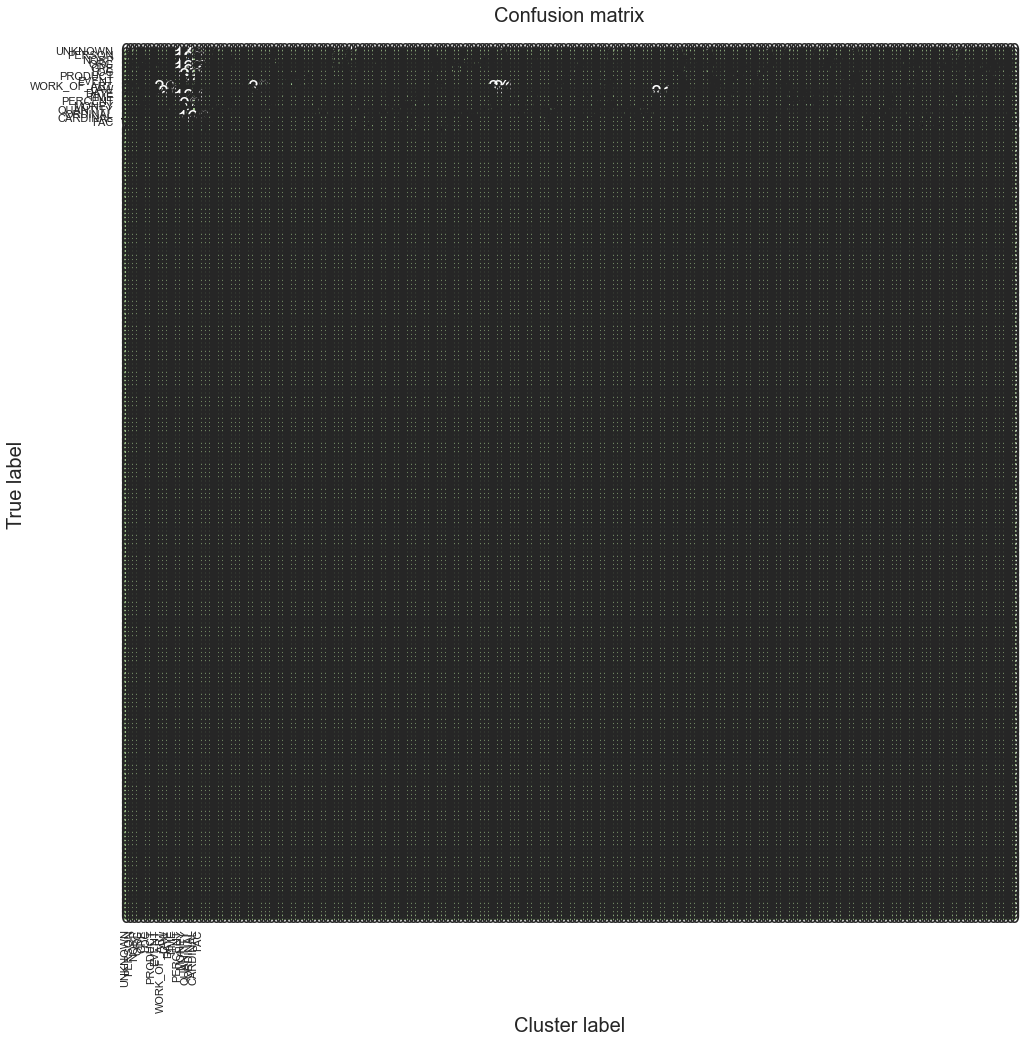



F1 score (macro) = 0.7630
Accuracy = 0.7437
Precision = 0.9542
Recall = 0.7489
... wrote results  <a href="c:\Users\Will\Projects\MSc\project\src\results\test-latent-all-OPTICS-AE\index.html">c:\Users\Will\Projects\MSc\project\src\results\test-latent-all-OPTICS-AE\index.html</a>
CPU times: total: 1h 15min 46s
Wall time: 5min 54s


In [39]:
%%time

dc = None
dc = DeepLatentCluster(
    'test-latent-all-OPTICS-AE',
    {
        'train_size':0,
        'reconstr_weight':1.0,
        'latent_weight':1e-5,
        "cluster": "OPTICS"
    })

dc.evaluate_model('test-latent-all', head="ae", sample_size=3000)

## GMM-AE

Autoencoder
Latent Model
model compiled
Loading AE weights from ./results/test-latent-all\ae_weights.h5
Loading model weights from ./results/test-latent-all\lat_model_final.h5
Using [ae] head for predictions
Load Data 
Test Data Loaded (185490, 768)
Predicting...16 batches of 256 x 768


  0%|          | 0/16 [00:00<?, ?it/s]

Clustering 4000 points using GMM
Initialization 0
Initialization converged: True	 time lapse 4.38114s	 ll 4124.95383
Visualising
UMAP(metric='manhattan', verbose=True)
Sun Aug 28 18:38:23 2022 Construct fuzzy simplicial set
Sun Aug 28 18:38:29 2022 Finding Nearest Neighbors
Sun Aug 28 18:38:29 2022 Finished Nearest Neighbor Search
Sun Aug 28 18:38:29 2022 Construct embedding


Epochs completed:   0%|            0/500 [00:00]

Sun Aug 28 18:38:36 2022 Finished embedding
CLUSTERS
#ORDINAL:0 size:198 prec:1.0000 rec:1.0000 f1:1.0000
#GPE:17 size:11 prec:1.0000 rec:0.0548 f1:0.1039
#QUANTITY:8 size:82 prec:1.0000 rec:0.5000 f1:0.6667
#EVENT:23 size:334 prec:1.0000 rec:0.8661 f1:0.9283
#PRODUCT:21 size:37 prec:1.0000 rec:0.3083 f1:0.4713
#MONEY:5 size:53 prec:1.0000 rec:1.0000 f1:1.0000
#LAW:11 size:109 prec:1.0000 rec:0.4932 f1:0.6606
#WORK_OF_ART:7 size:121 prec:1.0000 rec:1.0000 f1:1.0000
#UNK-QUANTITY-8:2 size:96 prec:1.0000 rec:0.5000 f1:0.6667
#NORP:18 size:21 prec:1.0000 rec:0.1694 f1:0.2897
#UNK-NORP-10:10 size:373 prec:1.0000 rec:0.4032 f1:0.5747
#UNK-LAW-11:6 size:216 prec:1.0000 rec:0.5068 f1:0.6727
#DATE:12 size:93 prec:1.0000 rec:1.0000 f1:1.0000
#FAC:13 size:120 prec:1.0000 rec:1.0000 f1:1.0000
#TIME:14 size:136 prec:1.0000 rec:0.3793 f1:0.5500
#PERSON:24 size:16 prec:1.0000 rec:0.1912 f1:0.3210
#LOC:16 size:59 prec:1.0000 rec:1.0000 f1:1.0000
#UNK-GPE-17:1 size:295 prec:1.0000 rec:0.9452 f1:0.9718

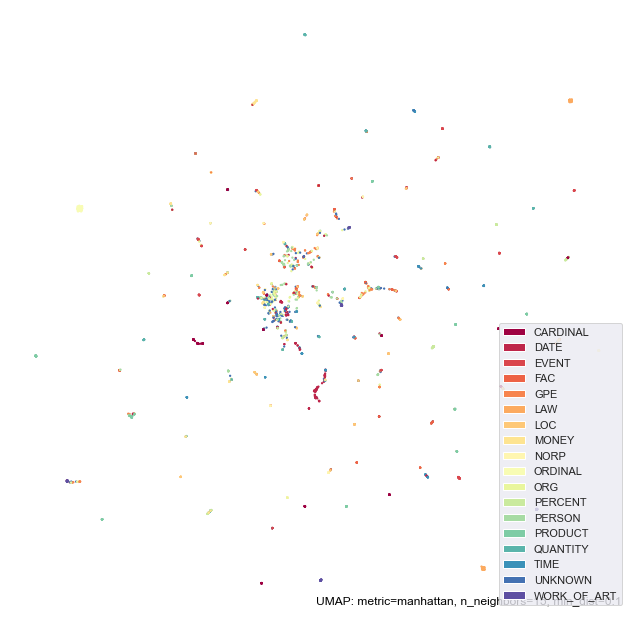

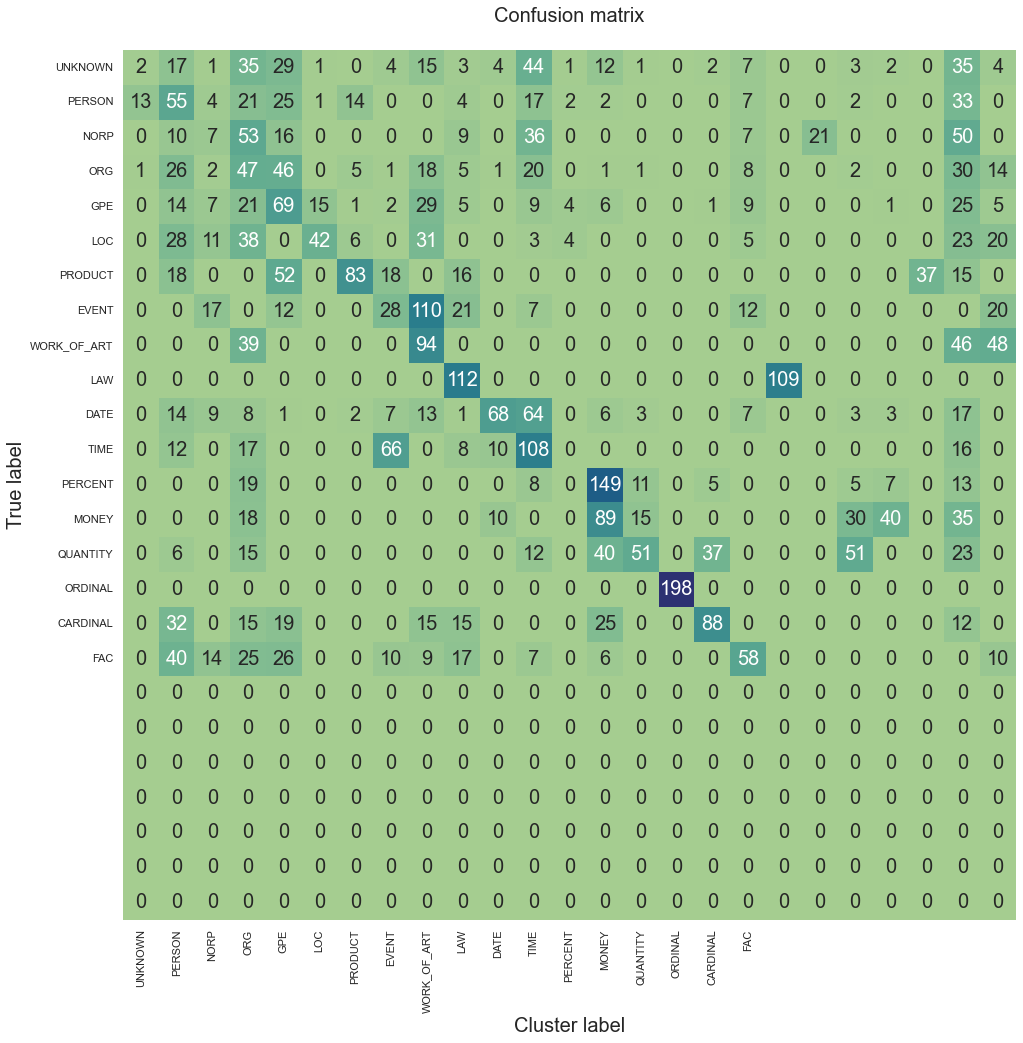



F1 score (macro) = 0.5550
Accuracy = 0.4805
Precision = 0.8943
Recall = 0.4843
... wrote results  <a href="c:\Users\Will\Projects\MSc\project\src\results\test-latent-all-GMM-AE2\index.html">c:\Users\Will\Projects\MSc\project\src\results\test-latent-all-GMM-AE2\index.html</a>
CPU times: total: 2min 29s
Wall time: 43.6 s


In [40]:
%%time

dc = None
dc = DeepLatentCluster(
    'test-latent-all-GMM-AE2',
    {
        'train_size':0,
        'reconstr_weight':1.0,
        'latent_weight':1e-5,
        "cluster": "GMM"
    })

dc.evaluate_model('test-latent-all', head="ae", sample_size=4000)

Autoencoder
Latent Model
model compiled
Loading AE weights from ./results/test-latent-all\ae_weights.h5
Loading model weights from ./results/test-latent-all\lat_model_final.h5
Using [ae] head for predictions
Load Data 
Test Data Loaded (185490, 768)
Predicting...16 batches of 256 x 768


  0%|          | 0/16 [00:00<?, ?it/s]

Clustering 4000 points using GMM
Initialization 0
Initialization converged: True	 time lapse 4.31844s	 ll 4168.21272
Visualising
UMAP(metric='manhattan', verbose=True)
Sun Aug 28 18:39:07 2022 Construct fuzzy simplicial set
Sun Aug 28 18:39:13 2022 Finding Nearest Neighbors
Sun Aug 28 18:39:13 2022 Finished Nearest Neighbor Search
Sun Aug 28 18:39:13 2022 Construct embedding


Epochs completed:   0%|            0/500 [00:00]

Sun Aug 28 18:39:20 2022 Finished embedding
CLUSTERS
#WORK_OF_ART:3 size:127 prec:1.0000 rec:0.2914 f1:0.4513
#TIME:10 size:185 prec:1.0000 rec:0.4824 f1:0.6508
#ORDINAL:2 size:341 prec:1.0000 rec:1.0000 f1:1.0000
#UNK-WORK_OF_ART-3:0 size:187 prec:1.0000 rec:0.2286 f1:0.3721
#FAC:9 size:103 prec:1.0000 rec:0.7722 f1:0.8714
#CARDINAL:5 size:183 prec:1.0000 rec:1.0000 f1:1.0000
#PRODUCT:20 size:23 prec:1.0000 rec:0.1642 f1:0.2821
#QUANTITY:7 size:261 prec:1.0000 rec:1.0000 f1:1.0000
#PERSON:17 size:262 prec:1.0000 rec:0.4494 f1:0.6202
#UNK-FAC-9:4 size:37 prec:1.0000 rec:0.2278 f1:0.3711
#UNK-TIME-10:1 size:433 prec:1.0000 rec:0.3367 f1:0.5038
#GPE:16 size:132 prec:1.0000 rec:0.6737 f1:0.8050
#UNK-PRODUCT-12:6 size:100 prec:1.0000 rec:0.2687 f1:0.4235
#PERCENT:13 size:105 prec:1.0000 rec:1.0000 f1:1.0000
#UNK-WORK_OF_ART-14:14 size:232 prec:1.0000 rec:0.4800 f1:0.6486
#LAW:15 size:197 prec:1.0000 rec:1.0000 f1:1.0000
#UNK-GPE-16:11 size:105 prec:1.0000 rec:0.3263 f1:0.4921
#UNK-PERSON-1

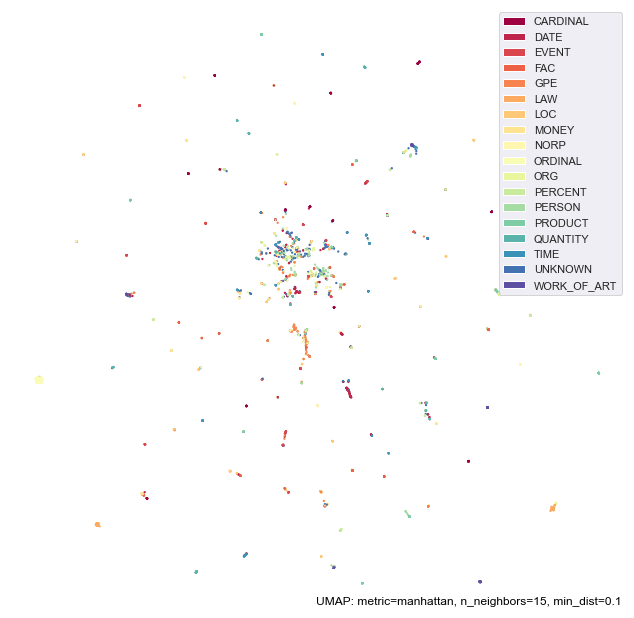

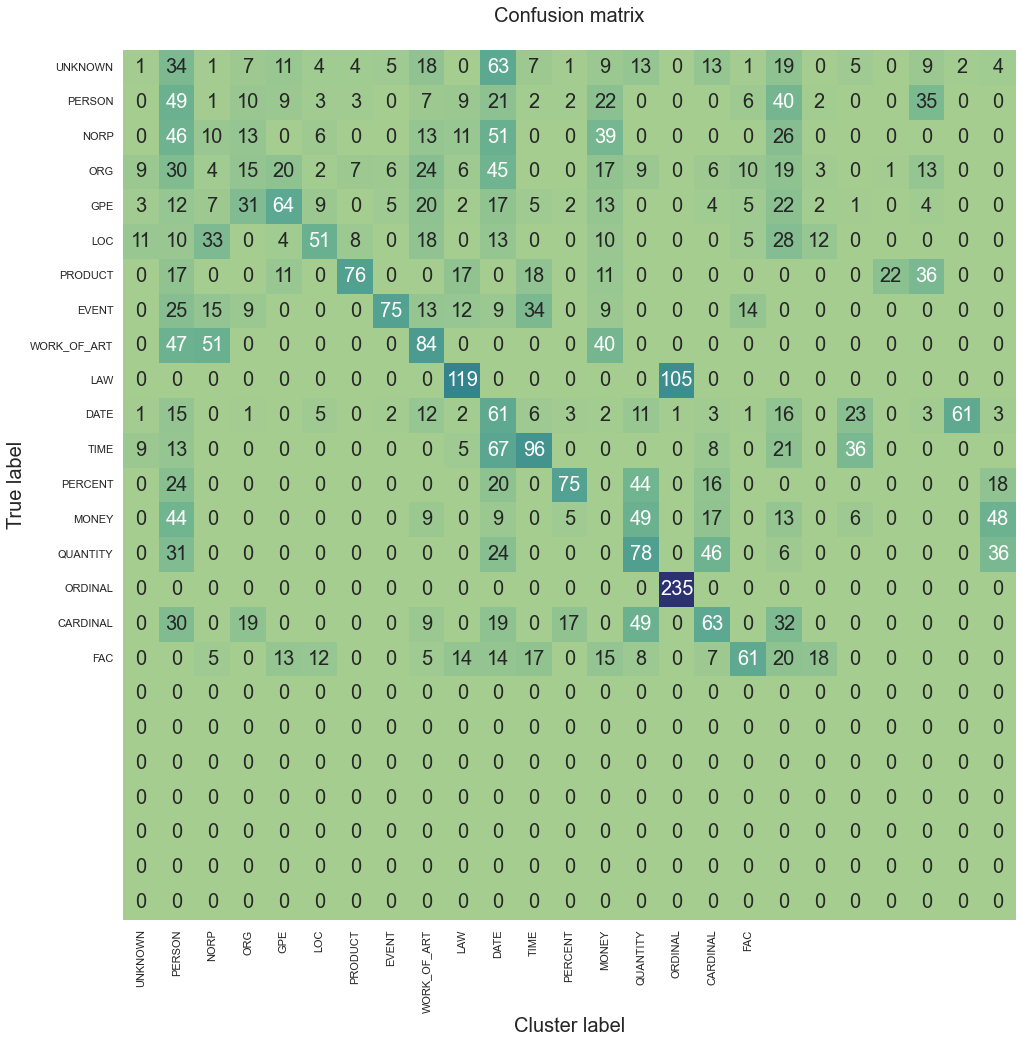



F1 score (macro) = 0.5223
Accuracy = 0.4545
Precision = 0.8387
Recall = 0.4498
... wrote results  <a href="c:\Users\Will\Projects\MSc\project\src\results\test-latent-all-GMM-AE\index.html">c:\Users\Will\Projects\MSc\project\src\results\test-latent-all-GMM-AE\index.html</a>
CPU times: total: 2min 26s
Wall time: 44.5 s


In [41]:
%%time

dc = None
dc = DeepLatentCluster(
    'test-latent-all-GMM-AE',
    {
        'train_size':0,
        'reconstr_weight':1.0,
        'latent_weight':1e-5,
        "cluster": "GMM"
    })

dc.evaluate_model('test-latent-all', head="ae", sample_size=4000)

## Kmeans-AE

Autoencoder
Latent Model
model compiled
Loading AE weights from ./results/test-latent-all\ae_weights.h5
Loading model weights from ./results/test-latent-all\lat_model_final.h5
Using [ae] head for predictions
Load Data 
Test Data Loaded (185490, 768)
Predicting...16 batches of 256 x 768


  0%|          | 0/16 [00:00<?, ?it/s]

Clustering 4000 points using Kmeans
Visualising
UMAP(metric='manhattan', verbose=True)
Sun Aug 28 18:39:45 2022 Construct fuzzy simplicial set
Sun Aug 28 18:39:52 2022 Finding Nearest Neighbors
Sun Aug 28 18:39:52 2022 Finished Nearest Neighbor Search
Sun Aug 28 18:39:52 2022 Construct embedding


Epochs completed:   0%|            0/500 [00:00]

Sun Aug 28 18:39:58 2022 Finished embedding
CLUSTERS
#PERSON:0 size:248 prec:1.0000 rec:1.0000 f1:1.0000
#WORK_OF_ART:23 size:154 prec:1.0000 rec:0.2055 f1:0.3409
#LAW:4 size:118 prec:1.0000 rec:0.5156 f1:0.6804
#MONEY:5 size:174 prec:1.0000 rec:0.5874 f1:0.7401
#UNK-LAW-4:2 size:226 prec:1.0000 rec:0.4844 f1:0.6527
#UNK-MONEY-5:3 size:146 prec:1.0000 rec:0.4126 f1:0.5842
#EVENT:14 size:106 prec:1.0000 rec:0.7442 f1:0.8533
#UNK-WORK_OF_ART-7:1 size:412 prec:1.0000 rec:0.1918 f1:0.3218
#CARDINAL:8 size:89 prec:1.0000 rec:1.0000 f1:1.0000
#PRODUCT:9 size:33 prec:1.0000 rec:0.2039 f1:0.3388
#ORDINAL:10 size:240 prec:1.0000 rec:1.0000 f1:1.0000
#UNK-PRODUCT-11:11 size:201 prec:1.0000 rec:0.2434 f1:0.3915
#FAC:24 size:89 prec:1.0000 rec:0.6667 f1:0.8000
#PERCENT:13 size:311 prec:1.0000 rec:1.0000 f1:1.0000
#UNK-EVENT-14:6 size:76 prec:1.0000 rec:0.2558 f1:0.4074
#UNK-PRODUCT-15:15 size:96 prec:1.0000 rec:0.5526 f1:0.7119
#TIME:16 size:153 prec:1.0000 rec:1.0000 f1:1.0000
#NORP:17 size:20 pr

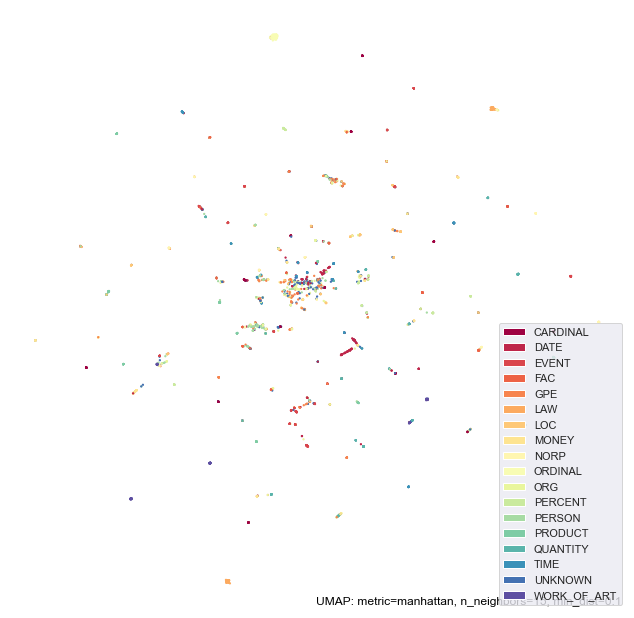

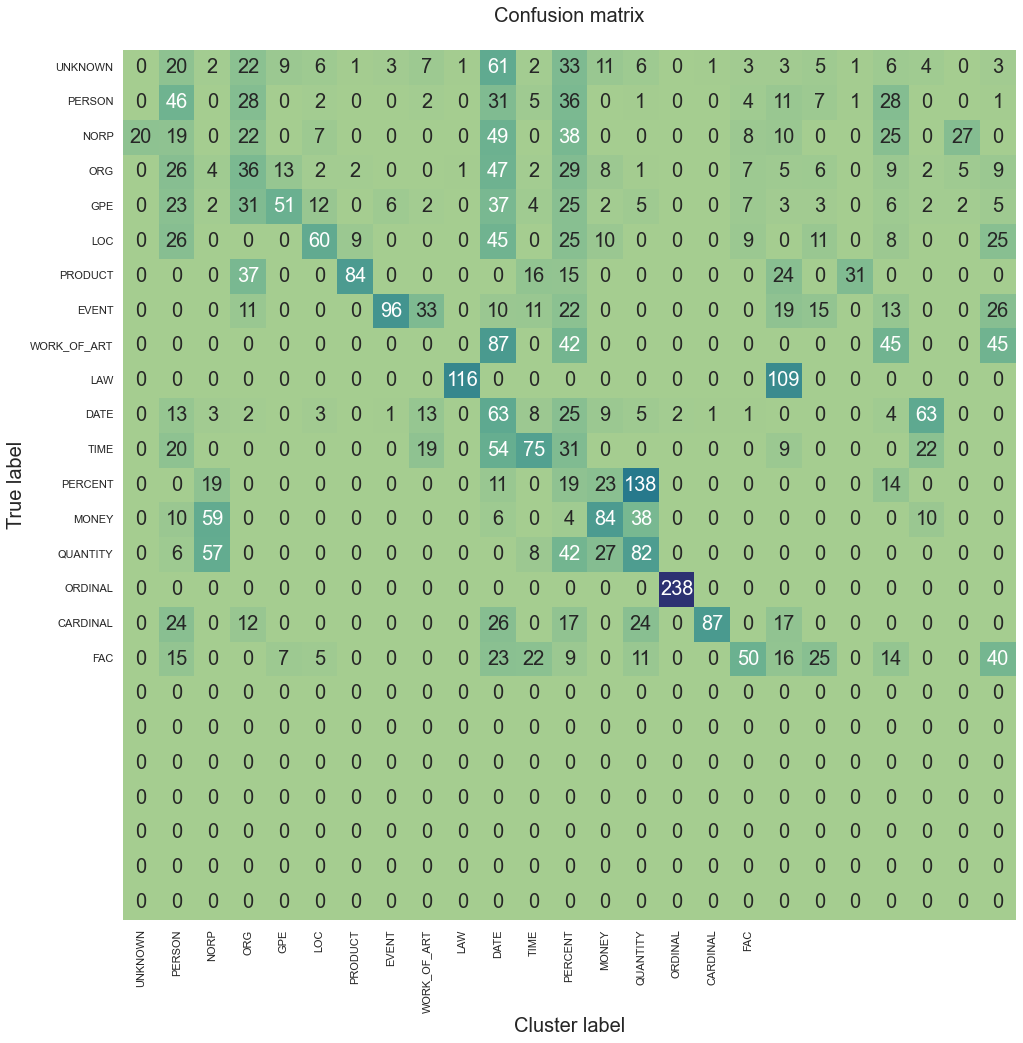



F1 score (macro) = 0.5428
Accuracy = 0.4895
Precision = 0.8385
Recall = 0.4894
... wrote results  <a href="c:\Users\Will\Projects\MSc\project\src\results\test-latent-all-Kmeans-AE\index.html">c:\Users\Will\Projects\MSc\project\src\results\test-latent-all-Kmeans-AE\index.html</a>
CPU times: total: 2min 19s
Wall time: 37.8 s


In [42]:
%%time

dc = None
dc = DeepLatentCluster(
    'test-latent-all-Kmeans-AE',
    {
        'train_size':0,
        'reconstr_weight':1.0,
        'latent_weight':1e-5,
        "cluster": "Kmeans"
    })

dc.evaluate_model('test-latent-all', head="ae", sample_size=4000)

In [43]:
stop

NameError: name 'stop' is not defined

# Benchmark

Load Data 
Test Data Loaded (185490, 768)
Clustering 2000 points using OPTICS
Visualising
UMAP(metric='manhattan', verbose=True)
Sun Aug 28 17:51:45 2022 Construct fuzzy simplicial set
Sun Aug 28 17:51:47 2022 Finding Nearest Neighbors
Sun Aug 28 17:51:47 2022 Finished Nearest Neighbor Search
Sun Aug 28 17:51:47 2022 Construct embedding


Epochs completed:   0%|            0/500 [00:00]

Sun Aug 28 17:51:51 2022 Finished embedding
CLUSTERS
#PRODUCT:0 size:8 prec:1.0000 rec:0.0702 f1:0.1311
#UNK-PRODUCT-1:1 size:8 prec:1.0000 rec:0.0702 f1:0.1311
#UNK-PRODUCT-2:2 size:6 prec:1.0000 rec:0.0526 f1:0.1000
#UNK-PRODUCT-3:3 size:8 prec:1.0000 rec:0.0702 f1:0.1311
#UNK-PRODUCT-4:4 size:10 prec:1.0000 rec:0.0877 f1:0.1613
#LOC:5 size:5 prec:1.0000 rec:0.0714 f1:0.1333
#UNK-LOC-6:6 size:8 prec:1.0000 rec:0.1143 f1:0.2051
#WORK_OF_ART:75 size:18 prec:1.0000 rec:0.1525 f1:0.2647
#LAW:8 size:70 prec:1.0000 rec:0.5224 f1:0.6863
#NORP:30 size:12 prec:1.0000 rec:0.1333 f1:0.2353
#MONEY:10 size:5 prec:1.0000 rec:0.0575 f1:0.1087
#PERCENT:11 size:5 prec:1.0000 rec:0.0847 f1:0.1562
#UNK-PERCENT-12:12 size:6 prec:1.0000 rec:0.1017 f1:0.1846
#UNK-PERCENT-13:13 size:6 prec:1.0000 rec:0.1017 f1:0.1846
#UNK-MONEY-14:14 size:5 prec:1.0000 rec:0.0575 f1:0.1087
#UNK-MONEY-15:15 size:5 prec:1.0000 rec:0.0575 f1:0.1087
#UNK-PERCENT-16:16 size:10 prec:1.0000 rec:0.1695 f1:0.2899
#UNK-PERCENT-17:17

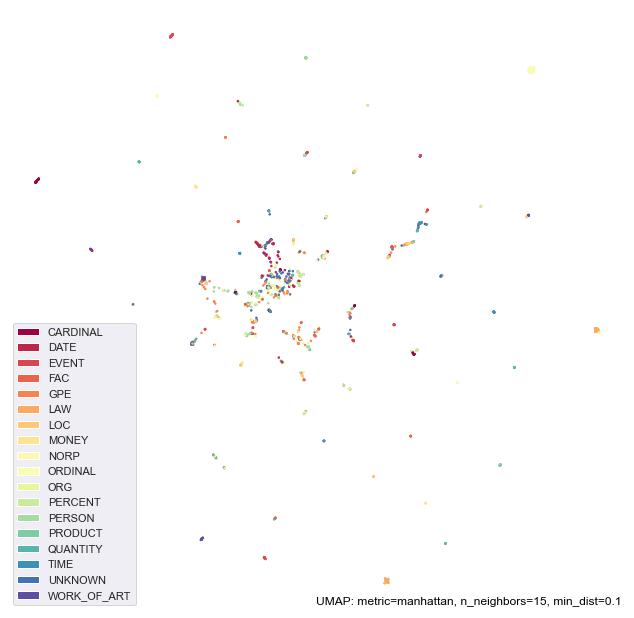

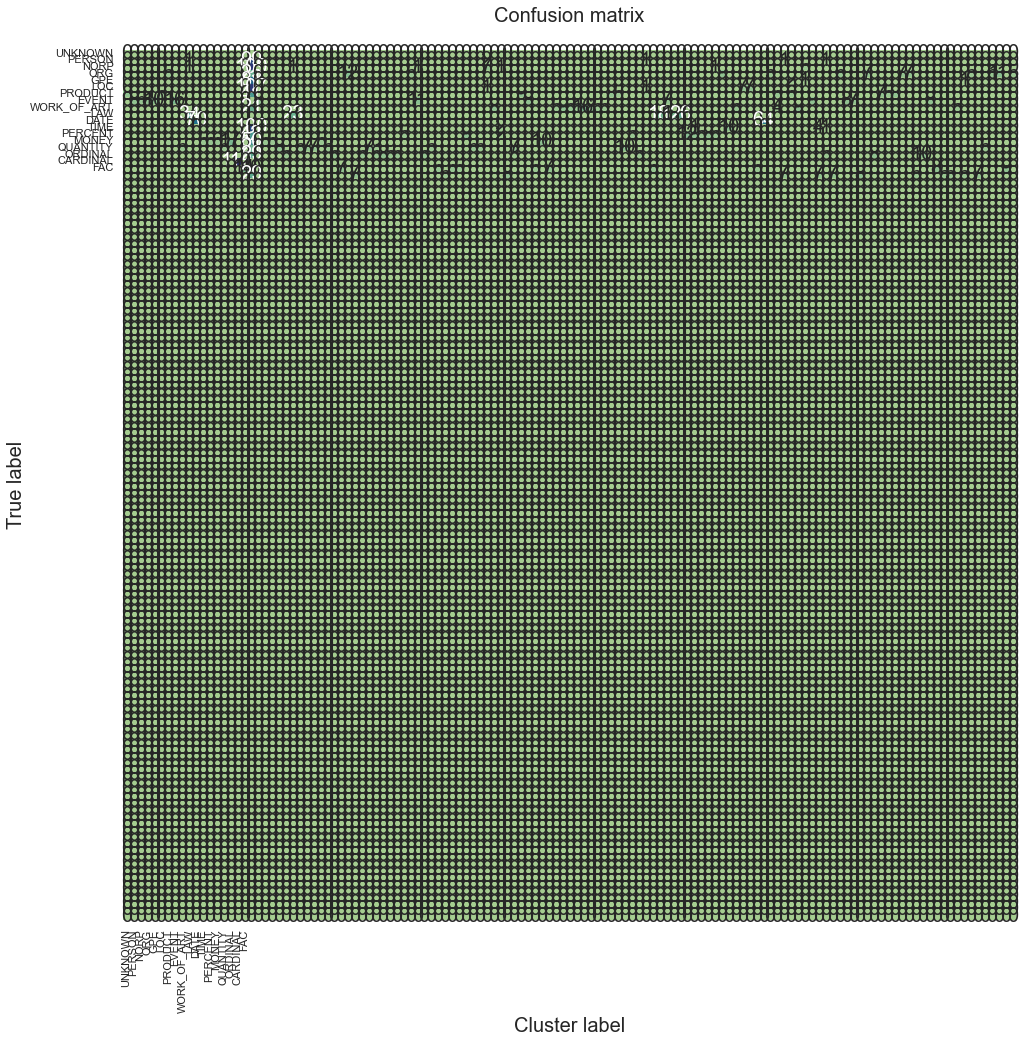



F1 score (macro) = 0.6791
Accuracy = 0.6515
Precision = 0.8962
Recall = 0.6499
... wrote results  <a href="c:\Users\Will\Projects\MSc\project\src\results\test-latent-10k-Benchmark\index.html">c:\Users\Will\Projects\MSc\project\src\results\test-latent-10k-Benchmark\index.html</a>


In [ ]:


dc = None
dc = DeepLatentCluster(
    'test-latent-10k-Benchmark',
    {
        'train_size':0,
        'reconstr_weight':1.0,
        'latent_weight':1e-5,
        "cluster": "OPTICS"
    })
# dc.make_model()
# dc.train_model()
dc.benchmark_model(sample_size=2000)

In [ ]:
stop

In [ ]:
tf.get_logger().setLevel('ERROR')

dc = DeepLatentCluster(
    'test-latent-all-10ent',
    {
        'entity_count': 10,
        'train_size':0,
        'reconstr_weight':1.0, 'latent_weight':1e-5
    })
dc.make_model()
# dc.train_model()

Autoencoder
Latent Model
Layer latent_0: 2000 activation=None
Layer latent_1: 500 activation=None
Layer latent_2: 500 activation=None
Layer latent_out: 2000 activation=sigmoid
model compiled


In [ ]:
dc.evaluate_model(10000, sample_size=1000)

Load Data
Loading ./data/conll_spacy_10000_test.pkl
LOADED {1: 'UNKNOWN', 2: 'PERSON', 4: 'ORG', 5: 'GPE', 11: 'DATE', 12: 'TIME', 8: 'EVENT', 16: 'ORDINAL', 3: 'NORP', 14: 'MONEY', 15: 'QUANTITY', 18: 'FAC', 6: 'LOC', 7: 'PRODUCT', 10: 'LAW', 9: 'WORK_OF_ART', 17: 'CARDINAL', 13: 'PERCENT'}
Loaded file: 12479 samples
Data balance:
[[    1 10305]
 [    2   404]
 [    3    24]
 [    4   439]
 [    5   668]
 [    6    44]
 [    7    14]
 [    8    24]
 [    9     5]
 [   10     2]
 [   11   380]
 [   12    31]
 [   13    38]
 [   14    30]
 [   15    29]
 [   16     1]
 [   17    15]
 [   18    26]]
Balancing data
Post Oversampling
x: (185490, 768), y: (185490,)
{0: 'UNKNOWN', 1: 'PERSON', 2: 'NORP', 3: 'ORG', 4: 'GPE', 5: 'LOC', 6: 'PRODUCT', 7: 'EVENT', 8: 'WORK_OF_ART', 9: 'LAW', 10: 'DATE', 11: 'TIME', 12: 'PERCENT', 13: 'MONEY', 14: 'QUANTITY', 15: 'ORDINAL', 16: 'CARDINAL', 17: 'FAC'}
Test Data Loaded
Autoencoder
Latent Model
Layer latent_0: 2000 activation=None
Layer latent_1: 500

  0%|          | 0/724 [00:00<?, ?it/s]

Clustering 1000 points
Initialization 0
Initialization converged: True	 time lapse 19.37085s	 ll 11881.56552
Visualising
UMAP(metric='manhattan', verbose=True)
Sat Aug 27 10:53:04 2022 Construct fuzzy simplicial set
Sat Aug 27 10:53:05 2022 Finding Nearest Neighbors
Sat Aug 27 10:53:07 2022 Finished Nearest Neighbor Search
Sat Aug 27 10:53:09 2022 Construct embedding


Epochs completed:   0%|            0/500 [00:00]

Sat Aug 27 10:53:11 2022 Finished embedding
CLUSTERS


# Hypertuning

In [ ]:
# optimal eps https://iopscience.iop.org/article/10.1088/1755-1315/31/1/012012/pdf

from sklearn.neighbors import NearestNeighbors

def optimal_eps(X, n_neighbors=10):
    neigh = NearestNeighbors(n_neighbors=2)
    nbrs = neigh.fit(X)
    distances, indices = nbrs.kneighbors(X)
    distances = np.sort(distances, axis=0)
    distances = distances[:,1]
    plt.plot(distances)

In [ ]:
def cluster_score(y, y_pred, n_clusters):
    """
    Compute the cluster score.
    Arguments:
        y: true labels.
        y_pred: predicted labels.
        n_clusters: number of clusters.
    Returns:
        cluster score.
    """
    # compute the cluster score
    score = 0
    for i in range(n_clusters):
        score += np.sum(y_pred[y==i]==i)
    return score/len(y)

In [ ]:
def hypertune_density_clustering():
    """
    hypertune the density clustering algorithms.
    """
    eps_vals = [30000.0, 40000.0, 50000.0]
    x, y, mapping, strings = load_data(
                                    1000,
                                    oversample=True,
                                    get_text=True)
    print(f"Optimal epsilon: {optimal_eps(x)}")
    for eps in eps_vals:
        # predict cluster labels
        print(f"Predicting...for epsilon={eps}")
        y_pred, _ = do_clustering('DBSCAN', 25, x, params={'eps':eps})
        print(f"ACC: {cluster_score(y, y_pred, 25)}")
        # confusion matrix
        cm_width = max(8, len(np.unique(y_pred)) * 2)
        cm_width = min(16, cm_width)
        plot_confusion(y, y_pred, mapping, size=cm_width, save_dir=None, details=False)

In [ ]:
hypertune_density_clustering()

In [ ]:
def run_benchmark(cluster:str, eval_size:int, n_clusters:int):
    x, y, mapping, strings = load_data(
                                    eval_size,
                                    oversample=False,
                                    get_text=True)
    save_dir = f'./results/bm/{cluster}'
    if not os.path.exists(save_dir):
        # create save dir
        os.makedirs(save_dir)

    
    # predict cluster labels
    print("Predicting...")
    y_pred, _ = do_clustering(cluster, n_clusters, x)
    # print(f"ACC: {cluster_acc(y, y_pred)}")
    
    # confusion matrix
    cm_width = max(8, len(np.unique(y_pred)) * 2)
    cm_width = min(16, cm_width)
    plot_confusion(y, y_pred, mapping, save_dir, cm_width)

    # show wordclouds for each cluster
    print ("BENCHMARK CLUSTERS")
    clusters = {}
    predicted = DataFrame({'text':strings, 'y_pred':y_pred, 'y_true':y})
    for cluster_no in range(n_clusters):
        y_pred_for_key = predicted[predicted['y_pred']==cluster_no]
        true_label = 'UNKNOWN'
        modal_value = y_pred_for_key['y_true'].mode()
        if len(modal_value)>0:
            if modal_value[0] in mapping:
                true_label = mapping[modal_value[0]]
            # confidence - fraction of this cluster that is actually this cluster
            y_true_this_cluster = len(
                y_pred_for_key[y_pred_for_key['y_true']==modal_value[0]])
            frac = y_true_this_cluster/len(y_pred_for_key)
        else:
            frac = 0

        # wordcloud
        unique, counts = np.unique(y_pred_for_key['text'], return_counts=True)
        freq_list = np.asarray((unique, counts)).T
        freq_list =  sorted(freq_list, key=lambda x: -x[1])[0:50]
        freqs = {w: f for w,f in freq_list}
        entry = {'freqs':freqs, 'frac':frac, 'n':len(y_pred_for_key)}
        if true_label == 'UNKNOWN':
            clusters[f"UNK-{cluster_no}"] = entry
        elif true_label in clusters:
            if clusters[true_label]['frac'] < frac:
                # we found a better cluster for this label
                clusters[true_label] = entry
            else:
                # this cluster is worse than this one, so it's unknown
                clusters[f"UNK-{cluster_no} Was {true_label}"] = entry
        else:
            clusters[true_label] = entry

    cluster_list = [{
        **clusters[c],
        'name': c,
        'idx': idx} for idx, c in enumerate(clusters)]
    cluster_list = sorted(cluster_list, key=lambda x: -x['frac'])

    display_list = []
    # show unknown clusters first
    for i, cluster in enumerate(cluster_list):
        if cluster['name'][0:3] == "UNK":
            save_file = os.path.join(save_dir,
                                     f"wordcloud-{cluster['name']}.png")
            show_wordcloud(i, cluster, save_file, save_only=True)
            display_list.append(cluster)

    # next show known clusters
    for i, cluster in enumerate(cluster_list):
        if cluster['name'][0:3] != "UNK":
            save_file = os.path.join(save_dir,
                                     f"wordcloud-{cluster['name']}.png")
            show_wordcloud(i, cluster, save_file, save_only=True)
            display_list.append(cluster)

    
    print(write_results_page(display_list, save_dir, cluster))

Loading ./data/conll_spacy_10000.pkl
LOADED {1: 'UNKNOWN', 4: 'ORG', 2: 'PERSON', 12: 'DATE', 5: 'GPE', 6: 'LOC', 16: 'QUANTITY', 14: 'PERCENT', 8: 'EVENT', 15: 'MONEY', 3: 'NORP', 17: 'ORDINAL', 19: 'FAC', 13: 'TIME', 18: 'CARDINAL', 7: 'PRODUCT', 10: 'LANGUAGE', 9: 'WORK_OF_ART', 11: 'LAW'}
Loaded file: 37748 samples
Data balance:
[[    1 31291]
 [    2  1454]
 [    3   102]
 [    4  1344]
 [    5  1842]
 [    6    80]
 [    7    21]
 [    8    32]
 [    9     8]
 [   10     5]
 [   11     5]
 [   12  1100]
 [   13   101]
 [   14    96]
 [   15    73]
 [   16    75]
 [   17     6]
 [   18    44]
 [   19    69]]
x: (37748, 768), y: (37748,)
{0: 'UNKNOWN', 1: 'PERSON', 2: 'NORP', 3: 'ORG', 4: 'GPE', 5: 'LOC', 6: 'PRODUCT', 7: 'EVENT', 8: 'WORK_OF_ART', 9: 'LANGUAGE', 10: 'LAW', 11: 'DATE', 12: 'TIME', 13: 'PERCENT', 14: 'MONEY', 15: 'QUANTITY', 16: 'ORDINAL', 17: 'CARDINAL', 18: 'FAC'}
Predicting...


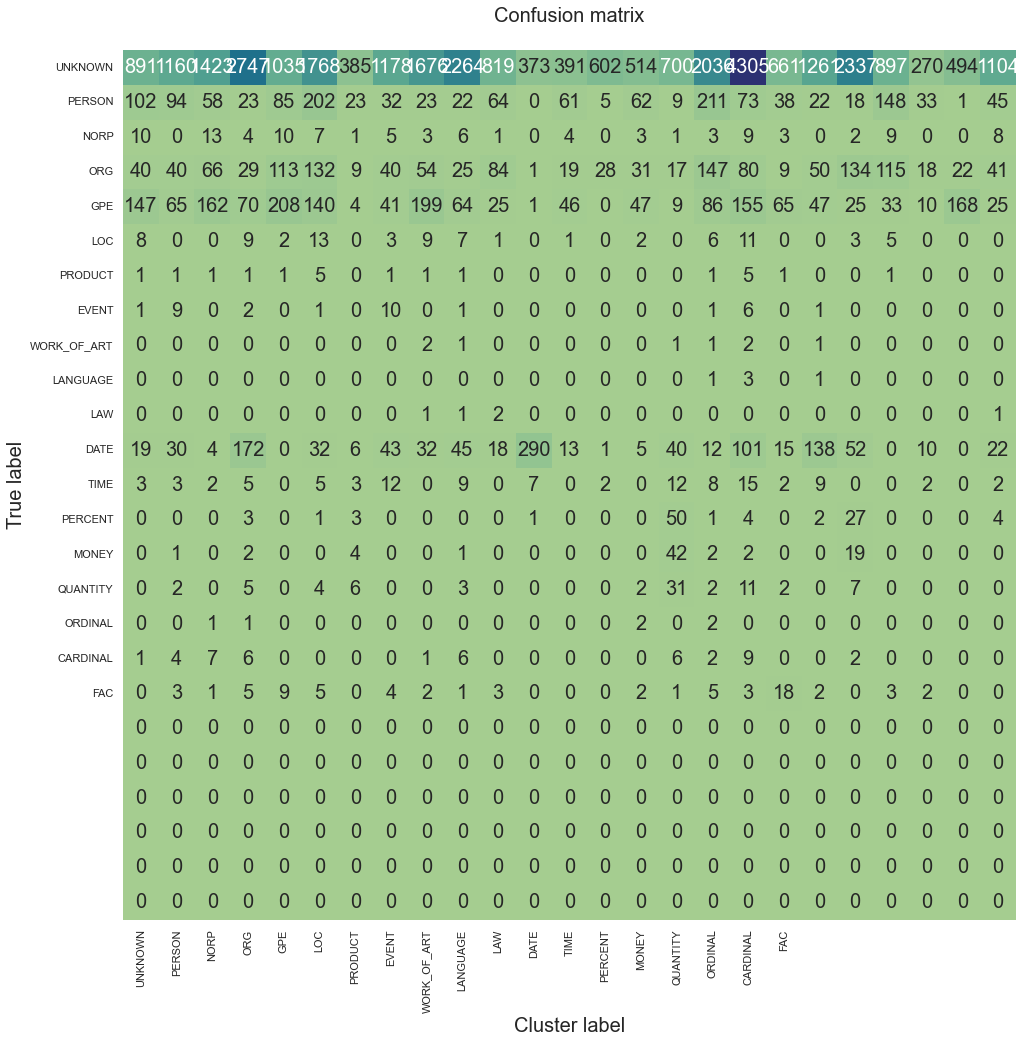

BENCHMARK CLUSTERS


TypeError: show_wordcloud() missing 3 required positional arguments: 'name', 'filepath', and 'n'

In [ ]:
run_benchmark('Kmeans', 10000, 25)

In [ ]:
run_benchmark('GMM', 10000, 25)

In [ ]:
run_benchmark('agg', 10000, 25)